# What was the impact of COVID-19 on online retail customers' behaviors?

We use mobility data to explore this question

## Data documentation

https://www.google.com/covid19/mobility/data_documentation.html?hl=en

https://support.google.com/covid19-mobility/answer/9825414?hl=en&ref_topic=9822927&sjid=14453184838721165415-NA

## Source
I downloaded the Google mobility data from https://github.com/ActiveConclusion/COVID19_mobility

Downloads from Google don't go back to 2020.

In [88]:
from datetime import date, datetime
import os

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

# For Amazon data, make easier to access col names by defining here
RESPONSE_ID = 'Survey ResponseID'
DATE = 'Order Date'
UNIT_PRICE = 'Purchase Price Per Unit'
QUANTITY = 'Quantity'
STATE = 'Shipping Address State'
TITLE = 'Title'
PRODUCT_CODE = 'ASIN/ISBN (Product Code)'
CATEGORY = 'Category'

# Additional / added columns
YEAR = 'year'

census_data_dir = '../data/census/'
mobility_data_fpath = '../data/mobility/google_mobility_report_US.csv'

## Load in the states data
For matching datasets.

In [89]:
states_df = pd.read_csv(census_data_dir + 'state-abbreviations.csv')
states_df.head(3)

state  abbrev code
0  Alabama    Ala.   AL
1   Alaska  Alaska   AK
2  Arizona   Ariz.   AZ

## Load in Google mobility data

In [90]:
goog_mobility_df = pd.read_csv(mobility_data_fpath, parse_dates=['date'])
# print(goog_mobility_df.shape)
# Drop rows where county is not total, because only interested in state series
goog_mobility_df = goog_mobility_df[goog_mobility_df['county']=='Total']
print(goog_mobility_df.shape)
# Drop 'county' column
goog_mobility_df = goog_mobility_df.drop('county', axis=1)
goog_mobility_df.head()

(37336, 9)


state       date  retail and recreation  grocery and pharmacy  parks   
0  Total 2020-02-15                    6.0                   2.0   15.0  \
1  Total 2020-02-16                    7.0                   1.0   16.0   
2  Total 2020-02-17                    6.0                   0.0   28.0   
3  Total 2020-02-18                    0.0                  -1.0    6.0   
4  Total 2020-02-19                    2.0                   0.0    8.0   

   transit stations  workplaces  residential  
0               3.0         2.0         -1.0  
1               2.0         0.0         -1.0  
2              -9.0       -24.0          5.0  
3               1.0         0.0          1.0  
4               1.0         1.0          0.0

In [100]:
print('What are the starting and ending dates?')
print(goog_mobility_df['date'].min().strftime('%Y-%m-%d'))
print(goog_mobility_df['date'].max().strftime('%Y-%m-%d'))

What are the starting and ending dates?
2020-02-15
2022-02-01


In [4]:
print('Which states are included?')
print('%s states' % goog_mobility_df['state'].nunique())

Which states are included?
52 states


Answer: All states + DC + 'Total'

In [5]:
print(goog_mobility_df['state'].unique())

['Total' 'Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'District of Columbia' 'Florida' 'Georgia'
 'Hawaii' 'Idaho' 'Illinois' 'Indiana' 'Iowa' 'Kansas' 'Kentucky'
 'Louisiana' 'Maine' 'Maryland' 'Massachusetts' 'Michigan' 'Minnesota'
 'Mississippi' 'Missouri' 'Montana' 'Nebraska' 'Nevada' 'New Hampshire'
 'New Jersey' 'New Mexico' 'New York' 'North Carolina' 'North Dakota'
 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania' 'Rhode Island' 'South Carolina'
 'South Dakota' 'Tennessee' 'Texas' 'Utah' 'Vermont' 'Virginia'
 'Washington' 'West Virginia' 'Wisconsin' 'Wyoming']


In [6]:
# Attach the state codes
state_codes_map = states_df.set_index('state')['code'].to_dict()
# Add in a code for the total US
state_codes_map['Total'] = 'US'
goog_mobility_df['state code'] = goog_mobility_df['state'].map(state_codes_map)
goog_mobility_df['state code'].value_counts().head()

state code
US    718
AL    718
NE    718
NV    718
NH    718
Name: count, dtype: int64

## Experimental plots

In [7]:
g_total = goog_mobility_df[goog_mobility_df['state']=='Total'].set_index('date')
g_total.head()

state  retail and recreation  grocery and pharmacy  parks   
date                                                                    
2020-02-15  Total                    6.0                   2.0   15.0  \
2020-02-16  Total                    7.0                   1.0   16.0   
2020-02-17  Total                    6.0                   0.0   28.0   
2020-02-18  Total                    0.0                  -1.0    6.0   
2020-02-19  Total                    2.0                   0.0    8.0   

            transit stations  workplaces  residential state code  
date                                                              
2020-02-15               3.0         2.0         -1.0         US  
2020-02-16               2.0         0.0         -1.0         US  
2020-02-17              -9.0       -24.0          5.0         US  
2020-02-18               1.0         0.0          1.0         US  
2020-02-19               1.0         1.0          0.0         US

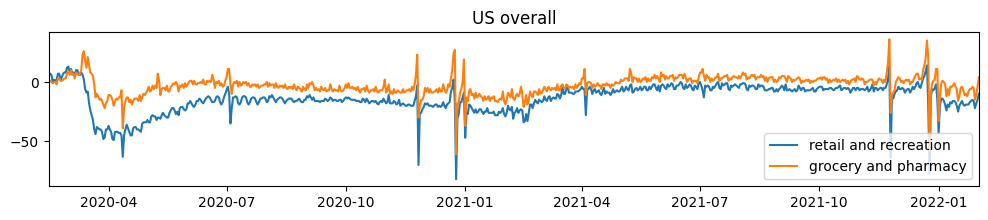

In [8]:
fig, ax = plt.subplots(1,1, figsize=(12,2))
retail_total = goog_mobility_df[goog_mobility_df['state']=='Total'].set_index('date')['retail and recreation']
groc_total = goog_mobility_df[goog_mobility_df['state']=='Total'].set_index('date')['grocery and pharmacy']
ax.plot(retail_total, label='retail and recreation')
ax.plot(groc_total, label='grocery and pharmacy')
ax.set_xlim(retail_total.index[0], retail_total.index[-1])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.legend()
_ = ax.set_title('US overall')

How different are the different states?
Make plots to
- compare retail and recreation
- compare grocery and pharmacy

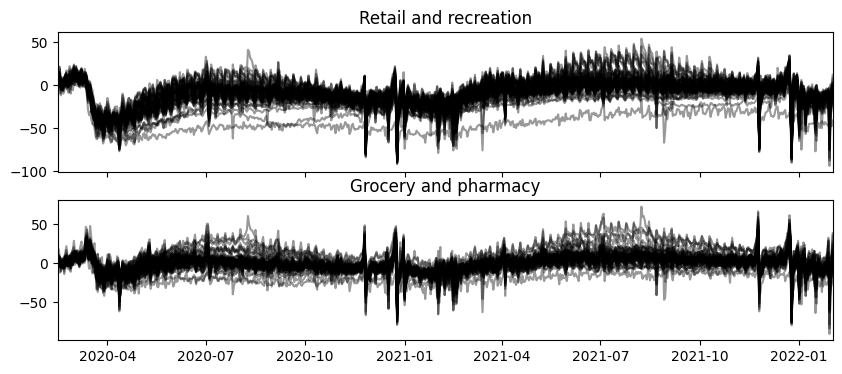

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax1.set_title('Retail and recreation')
ax2.set_title('Grocery and pharmacy')
state_codes = goog_mobility_df['state code'].dropna().unique()
ax1.set_xlim(retail_total.index[0], retail_total.index[-1])
for s, s_code in enumerate(state_codes):
    s_df = goog_mobility_df[goog_mobility_df['state code']==s_code].set_index('date')
    ax1.plot(s_df['retail and recreation'], label=s_code, color='black', alpha=0.4)
    ax2.plot(s_df['grocery and pharmacy'], label=s_code, color='black', alpha=0.4)

## Weekly and monthly timeseries

Create a weekly timeseries where
- index is week
- each column is US/Total or a state code

In [10]:
retail_daily = pd.DataFrame({
   s_code:  goog_mobility_df[goog_mobility_df['state code']==s_code].set_index('date')['retail and recreation'] for s_code in goog_mobility_df['state code'].unique()
})
retail_daily.head(3)

US   AL    AK   AZ   AR   CA   CO    CT    DE    DC  ...    SD   
date                                                              ...         
2020-02-15  6.0  5.0   5.0  3.0  3.0  1.0  2.0   4.0   7.0  -2.0  ...   7.0  \
2020-02-16  7.0  0.0  15.0  7.0  5.0  5.0  7.0   5.0   6.0   6.0  ...  15.0   
2020-02-17  6.0  3.0   3.0  9.0  1.0  9.0  5.0  11.0  12.0 -10.0  ...   3.0   

             TN   TX    UT    VT   VA    WA   WV    WI   WY  
date                                                         
2020-02-15  7.0  3.0   2.0  10.0  2.0   2.0  7.0   7.0  4.0  
2020-02-16  6.0  8.0   5.0  22.0  4.0  15.0  7.0  12.0  5.0  
2020-02-17  6.0  6.0  18.0  19.0  8.0  12.0  5.0  -6.0  2.0  

[3 rows x 52 columns]

In [11]:
# feb 16, 2020 is a sunday
retail_weekly = retail_daily.resample('W', label='left').mean()
retail_weekly.head(3)

US         AL         AK        AZ         AR        CA   
date                                                                        
2020-02-09  6.500000   2.500000  10.000000  5.000000   4.000000  3.000000  \
2020-02-16  3.571429   1.000000   2.857143  3.714286   1.714286  2.285714   
2020-02-23  7.714286  10.857143  10.714286  7.571429  13.571429  4.000000   

                  CO        CT        DE        DC  ...         SD        TN   
date                                                ...                        
2020-02-09  4.500000  4.500000  6.500000  2.000000  ...  11.000000  6.500000  \
2020-02-16 -0.285714  4.857143  5.142857 -2.285714  ...   2.571429  1.428571   
2020-02-23  4.428571  5.142857  6.714286  1.142857  ...   6.285714  9.714286   

                  TX        UT         VT        VA        WA         WV   
date                                                                       
2020-02-09  5.500000  3.500000  16.000000  3.000000  8.500000   7.000000  \
2020-02-16  1.571429  6.285714   7.428571  2.142857  6.000000   4.285714   
2020-02-23  9.000000  6.714286   5.285714  5.714286  8.428571  10.857143   

                  WI        WY  
date                            
2020-02-09  9.500000  4.500000  
2020-02-16  2.857143  3.857143  
2020-02-23  7.000000  5.285714  

[3 rows x 52 columns]

In [12]:
retail_monthly = retail_daily.resample('M', label='left').mean()
retail_monthly.head(3)

US         AL         AK         AZ         AR         CA   
date                                                                           
2020-01-31   5.266667   4.800000   6.466667   5.133333   6.466667   3.000000  \
2020-02-29 -15.580645 -10.193548 -12.096774 -12.354839  -7.709677 -20.096774   
2020-03-31 -41.433333 -31.533333 -31.300000 -37.266667 -23.566667 -50.300000   

                   CO         CT         DE         DC  ...         SD   
date                                                    ...              
2020-01-31   2.000000   4.600000   5.600000  -0.400000  ...   4.333333  \
2020-02-29 -18.612903 -18.064516 -13.806452 -28.903226  ... -11.935484   
2020-03-31 -42.533333 -43.700000 -40.100000 -64.100000  ... -33.966667   

                   TN         TX         UT         VT         VA         WA   
date                                                                           
2020-01-31   5.000000   4.733333   6.400000   7.066667   3.400000   6.666667  \
2020-02-29 -10.870968 -13.483871 -14.161290 -19.645161 -13.645161 -20.032258   
2020-03-31 -32.033333 -37.033333 -33.766667 -48.900000 -38.400000 -40.200000   

                   WV         WI         WY  
date                                         
2020-01-31   6.533333   4.600000   4.866667  
2020-02-29 -10.870968 -19.161290 -12.774194  
2020-03-31 -33.333333 -42.966667 -31.933333  

[3 rows x 52 columns]

In [13]:
grocery_daily = pd.DataFrame({
   s_code:  goog_mobility_df[goog_mobility_df['state code']==s_code].set_index('date')['grocery and pharmacy'] for s_code in goog_mobility_df['state code'].unique()
})
grocery_daily.head()

US   AL   AK   AZ   AR   CA   CO   CT   DE    DC  ...    SD   TN   
date                                                           ...              
2020-02-15  2.0  2.0  3.0  2.0  2.0  1.0  3.0 -4.0  2.0  -2.0  ...   6.0  4.0  \
2020-02-16  1.0 -2.0  5.0  3.0  4.0  0.0  5.0 -5.0  2.0  -1.0  ...  11.0  1.0   
2020-02-17  0.0  0.0 -2.0  1.0 -2.0  1.0  2.0  1.0  2.0 -12.0  ...   0.0 -2.0   
2020-02-18 -1.0 -3.0 -2.0  2.0 -4.0  0.0 -4.0 -5.0  0.0  -2.0  ...   1.0 -3.0   
2020-02-19  0.0  1.0 -2.0  2.0  1.0  0.0 -4.0 -1.0  0.0  -3.0  ...  -1.0  3.0   

             TX   UT    VT   VA   WA   WV   WI   WY  
date                                                 
2020-02-15  3.0  3.0   2.0  2.0 -1.0 -3.0  6.0  3.0  
2020-02-16  3.0  3.0  11.0  0.0  3.0  1.0  6.0  2.0  
2020-02-17  2.0  8.0   9.0  2.0  2.0 -2.0 -2.0  2.0  
2020-02-18 -1.0  5.0  -4.0  2.0  2.0 -1.0  0.0  4.0  
2020-02-19  0.0  6.0   2.0  2.0  3.0 -3.0  0.0  0.0  

[5 rows x 52 columns]

In [14]:
grocery_weekly = grocery_daily.resample('W', label='left').mean()
grocery_weekly.head(3)

US        AL        AK        AZ        AR        CA   
date                                                                     
2020-02-09  1.500000  0.000000  4.000000  2.500000  3.000000  0.500000  \
2020-02-16  0.428571 -0.285714  0.285714  0.714286 -0.571429  0.428571   
2020-02-23  3.714286  5.285714  5.714286  4.142857  6.428571  2.571429   

                  CO        CT        DE        DC  ...         SD        TN   
date                                                ...                        
2020-02-09  4.000000 -4.500000  2.000000 -1.500000  ...   8.500000  2.500000  \
2020-02-16  0.571429 -1.714286  1.428571 -4.000000  ...   5.000000 -0.285714   
2020-02-23  4.428571  1.142857  2.428571 -3.571429  ...  10.285714  4.714286   

                  TX         UT        VT   VA        WA        WV        WI   
date                                                                           
2020-02-09  3.000000   3.000000  6.500000  1.0  1.000000 -1.000000  6.000000  \
2020-02-16  0.142857   7.714286  2.428571  1.0  1.285714 -1.714286  2.285714   
2020-02-23  5.714286  10.428571  0.714286  4.0  3.857143  2.428571  3.857143   

                  WY  
date                  
2020-02-09  2.500000  
2020-02-16  5.000000  
2020-02-23  7.142857  

[3 rows x 52 columns]

In [15]:
grocery_monthly = grocery_daily.resample('M', label='left').mean()
grocery_monthly.head(3)

US        AL        AK         AZ        AR         CA   
date                                                                        
2020-01-31   1.533333  1.666667  2.400000   2.133333  2.333333   1.266667  \
2020-02-29   1.806452  6.387097  1.741935   2.354839  5.548387  -1.000000   
2020-03-31 -14.833333 -6.000000 -9.866667 -14.900000 -1.433333 -18.233333   

                   CO         CT         DE         DC  ...        SD   
date                                                    ...             
2020-01-31   2.266667  -1.200000   1.600000  -3.866667  ...  6.866667  \
2020-02-29   1.548387   0.774194  -3.096774  -9.258065  ...  9.741935   
2020-03-31 -19.266667 -19.200000 -20.466667 -32.500000  ... -2.866667   

                  TN         TX         UT         VT         VA         WA   
date                                                                          
2020-01-31  1.666667   2.533333   8.333333   1.600000   1.866667   1.866667  \
2020-02-29  6.161290   2.935484  10.258065  -5.774194   1.645161  -1.516129   
2020-03-31 -6.366667 -15.033333  -9.400000 -26.600000 -14.400000 -14.066667   

                   WV         WI        WY  
date                                        
2020-01-31  -0.666667   2.866667  5.800000  
2020-02-29   0.967742  -0.935484  8.419355  
2020-03-31 -11.033333 -14.966667 -7.200000  

[3 rows x 52 columns]

### Experiment with more plots 

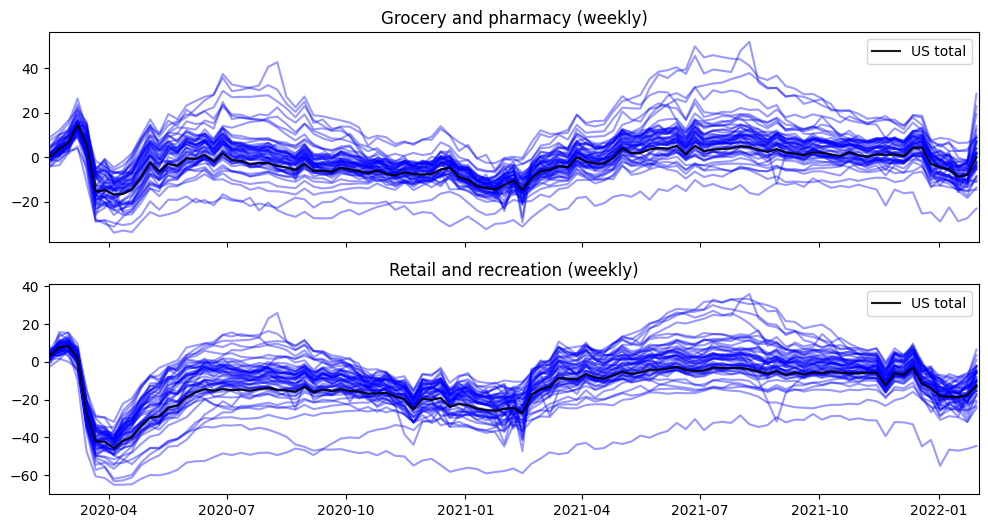

In [16]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax1.set_title('Grocery and pharmacy (weekly)')
ax2.set_title('Retail and recreation (weekly)')
ax1.set_xlim(retail_total.index[0], retail_total.index[-1])
for s, s_code in enumerate(state_codes):
    #if s > 10: break
    ax1.plot(grocery_weekly[s_code], color='blue', alpha=0.4)#, label=s_code)
    ax2.plot(retail_weekly[s_code], color='blue', alpha=0.4)#, label=s_code)
ax1.plot(grocery_weekly['US'], label='US total', color='black', alpha=0.9)
ax2.plot(retail_weekly['US'], label='US total', color='black', alpha=0.9)
ax1.legend()
_ = ax2.legend()

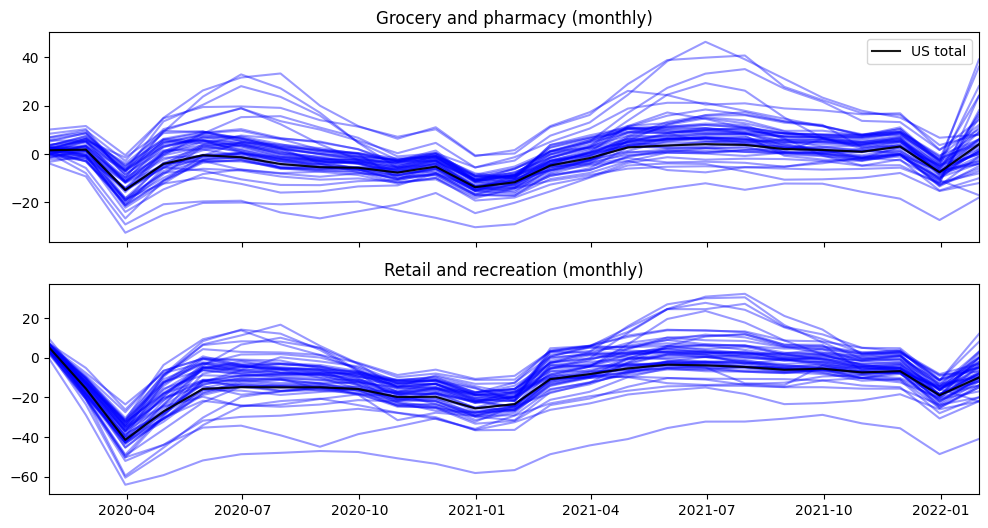

In [17]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,6), sharex=True)
ax1.set_title('Grocery and pharmacy (monthly)')
ax2.set_title('Retail and recreation (monthly)')
ax2.set_xlim(retail_monthly.index[0], retail_monthly.index[-1])
for s, s_code in enumerate(state_codes):
    ax1.plot(grocery_monthly[s_code], color='blue', alpha=0.4)#, label=s_code)
    ax2.plot(retail_monthly[s_code], color='blue', alpha=0.4)#, label=s_code)
ax1.plot(grocery_monthly['US'], label='US total', color='black', alpha=0.9)
ax2.plot(retail_monthly['US'], label='US total', color='black', alpha=0.9)
_ = ax1.legend()

### Plots to compare daily and monthly state indices

Grocery and pharmacy Google  (daily and monthly)


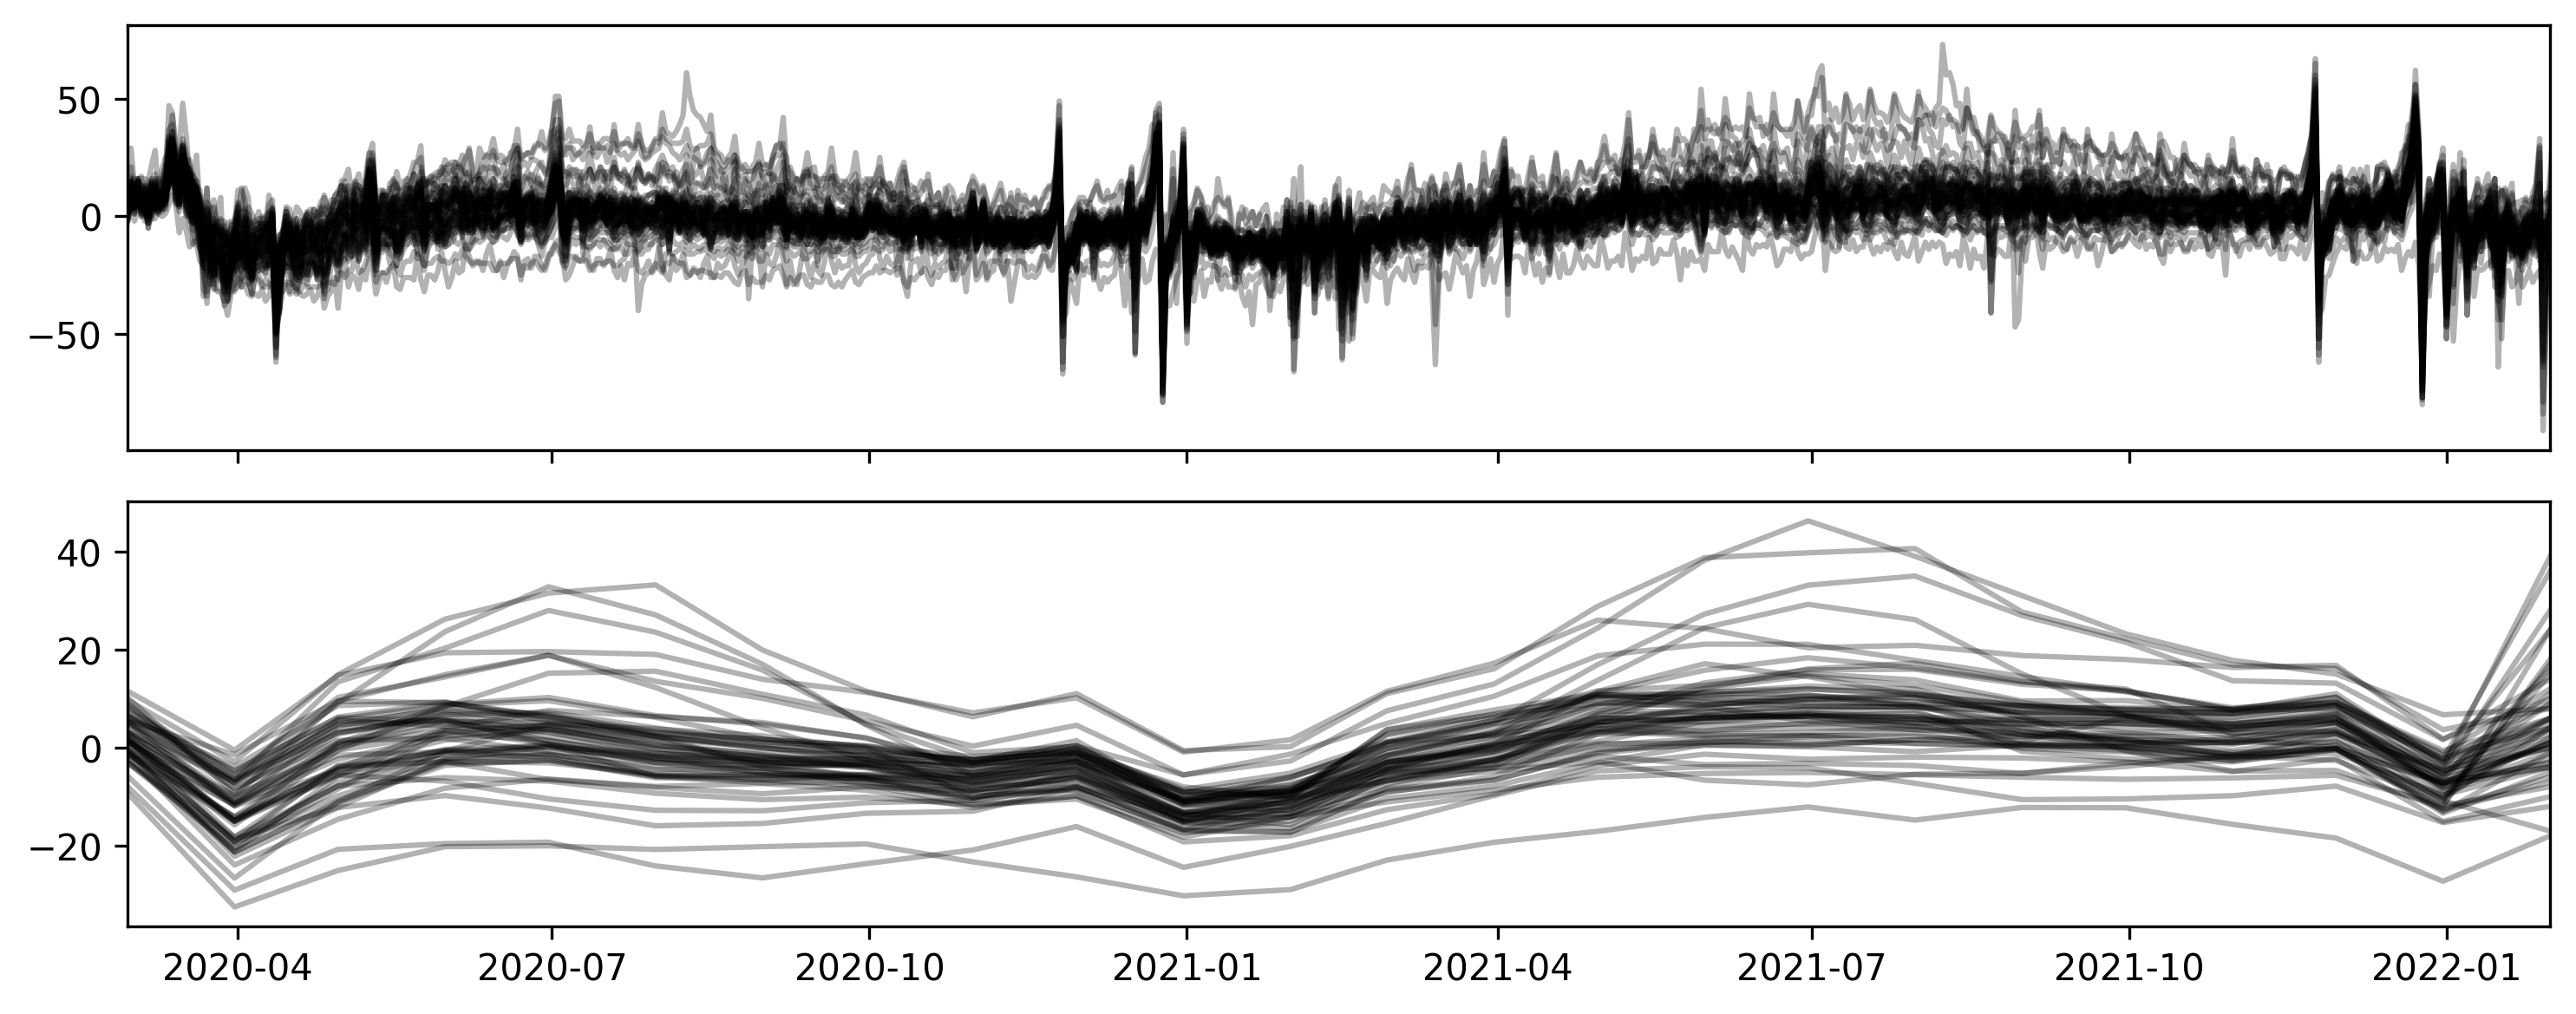

In [20]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10, 4), sharex=True, dpi=300)
print('Grocery and pharmacy Google  (daily and monthly)')
ax2.set_xlim(grocery_monthly.index[1], grocery_monthly.index[-1])
for s, s_code in enumerate(state_codes):
    ax1.plot(grocery_daily[s_code], color='black', alpha=0.3)#, label=s_code)
    ax2.plot(grocery_monthly[s_code], color='black', alpha=0.3)#, label=s_code)
# ax1.plot(grocery_daily['US'], label='US total', color='black', alpha=0.9)
# ax2.plot(grocery_monthly['US'], label='US total', color='black', alpha=0.9)
plt.tight_layout()
# _ = ax1.legend()

## Amazon purchases


In [21]:
amzn_data_fpath = '../data/amazon-data/amazon-data-cleaned.csv'
amzn_data = pd.read_csv(amzn_data_fpath, parse_dates=[DATE])
# exclude data beyond 2022-10-31 because we began data collection in 2022-11
amzn_data = amzn_data[amzn_data[DATE] <= datetime.strptime('2022-10-31', '%Y-%m-%d')]
amzn_data[YEAR] = amzn_data[DATE].apply(lambda d: d.year)
# peek at it:
amzn_data.head(3)

Order Date  Purchase Price Per Unit  Quantity Shipping Address State   
0 2018-12-04                     7.98       1.0                     NJ  \
1 2018-12-22                    13.99       1.0                     NJ   
2 2018-12-24                     8.99       1.0                     NJ   

                                               Title ASIN/ISBN (Product Code)   
0  SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...               B0143RTB1E  \
1  Betron BS10 Earphones Wired Headphones in Ear ...               B01MA1MJ6H   
2                                                NaN               B078JZTFN3   

       Category  Survey ResponseID  year  
0  FLASH_MEMORY  R_01vNIayewjIIKMF  2018  
1    HEADPHONES  R_01vNIayewjIIKMF  2018  
2           NaN  R_01vNIayewjIIKMF  2018

### Amazon prime day

Get the dates for Amazon prime day, as this impact purchases

In [22]:
amzn_prime_ds = [
    '2018-07-16',
    '2019-07-15',
    '2020-10-13',
    '2021-06-21',
    '2022-07-13',
]
amzn_prime_dates = [datetime.strptime(d, '%Y-%m-%d') for d in amzn_prime_ds]
# set to the end of the month since that's how the other metrics are summed
amzn_prime_ms = [
    '2018-06-30', # july (07)
    '2019-06-30', # july (07)
    '2020-09-30', # october
    '2021-05-31', # june (06)
    '2022-06-30', # july (07)
]
amzn_prime_months = [datetime.strptime(m, '%Y-%m-%d') for m in amzn_prime_ms]

### Amazon purchasing metrics

timeseries metrics (weekly and monthly):
- distinct purchasers
- grocery purchasers / [categories] purchasers

In [23]:
def get_purchasers(df, categories=None, products=None, state=None, period='M'):
    mdf = df.copy() if state is None else df[df[STATE]==state].copy()
    if categories is not None:
        mdf = mdf[mdf[CATEGORY].isin(categories)]
    elif products is not None:
        mdf = mdf[mdf[PRODUCT_CODE].isin(products)]
    if period=='M': # monthly
        return mdf.groupby(DATE)[RESPONSE_ID].nunique().resample('M', label='left').mean().rename('unique purchasers')
    if period=='W': # weekly, will use sunday
        return mdf.groupby(DATE)[RESPONSE_ID].nunique().resample('W', label='left').mean().rename('unique purchasers')
    return NotImplemented

#### Get grocery related products

Turns out more data makes a difference


In [24]:
groc_cats0 = ['GROCERY', 'FOOD', 'VEGETABLE']
groc_purchases = amzn_data[amzn_data[CATEGORY].isin(groc_cats0)]
groc_products = groc_purchases[PRODUCT_CODE].unique()
print('%s GROCERY purchases when using %s grocery categories' % (len(groc_purchases), len(groc_cats0)))
print('%s GROCERY products' % len(groc_products))

34348 GROCERY purchases when using 3 grocery categories
8667 GROCERY products


In [25]:
groc_purchases = amzn_data[amzn_data[PRODUCT_CODE].isin(groc_products)]
print('%s expanded grocery purchases' % len(groc_purchases))
print('%s grocery related categories' % groc_purchases[CATEGORY].nunique())
groc_cats_vcounts = groc_purchases[CATEGORY].value_counts()
groc_cats_vcounts.head(20)

44048 expanded grocery purchases
350 grocery related categories


Category
GROCERY                   11667
FOOD                      11414
VEGETABLE                 11267
FRUIT                       534
DAIRY_BASED_CHEESE          516
BREAD                       405
POULTRY                     382
DRINK_FLAVORED              344
SNACK_CHIP_AND_CRISP        282
HERB                        241
MEAT                        232
FRUIT_SNACK                 202
SAUCE                       198
NUT_AND_SEED                196
SNACK_MIX                   189
WATER                       167
DAIRY_BASED_CREAM           164
NOODLE                      163
PUFFED_SNACK                158
PACKAGED_SOUP_AND_STEW      156
Name: count, dtype: int64

In [26]:
# Take the categories for grocery related purchases with at least threshold purchases
threshold = 40
groc_cats = groc_cats_vcounts[groc_cats_vcounts >= threshold].index.tolist()
# print(groc_cats)
# Remove some bad categories
groc_cats.remove('HEADPHONES')
groc_cats.remove('PET_FOOD') # keep it to human groceries only (better results too)
print('%s expanded grocery related categories' % (len(groc_cats)))
print(groc_cats)

56 expanded grocery related categories
['GROCERY', 'FOOD', 'VEGETABLE', 'FRUIT', 'DAIRY_BASED_CHEESE', 'BREAD', 'POULTRY', 'DRINK_FLAVORED', 'SNACK_CHIP_AND_CRISP', 'HERB', 'MEAT', 'FRUIT_SNACK', 'SAUCE', 'NUT_AND_SEED', 'SNACK_MIX', 'WATER', 'DAIRY_BASED_CREAM', 'NOODLE', 'PUFFED_SNACK', 'PACKAGED_SOUP_AND_STEW', 'MILK_SUBSTITUTE', 'CRACKER', 'COOKIE', 'SUGAR_CANDY', 'SYRUP', 'DAIRY_BASED_BUTTER', 'BREAKFAST_CEREAL', 'COFFEE', 'TEA', 'SNACK_FOOD_BAR', 'POPCORN', 'LEAVENING_AGENT', 'Grocery', 'DAIRY_BASED_YOGURT', 'CHOCOLATE_CANDY', 'EDIBLE_OIL_VEGETABLE', 'JUICE_AND_JUICE_DRINK', 'SEASONING', 'CAKE', 'DAIRY_BASED_ICE_CREAM', 'DAIRY_BASED_DRINK', 'CONDIMENT', 'LEGUME', 'RICE_MIX', 'CHEWING_GUM', 'FISH', 'CULINARY_SALT', 'SUGAR', 'NUTRITIONAL_SUPPLEMENT', 'NUT_BUTTER', 'PASTRY', 'THICKENING_AGENT', 'CEREAL', 'BAKING_MIX', 'SALAD_DRESSING', 'HERBAL_SUPPLEMENT']


In [27]:
groc_purchases = amzn_data[amzn_data[CATEGORY].isin(groc_cats)]
groc_products = groc_purchases[PRODUCT_CODE].unique().tolist()
print('%s expanded grocery purchases' % len(groc_purchases))
print('%s grocery related products' % groc_purchases[PRODUCT_CODE].nunique())
print('%s grocery related categories' % groc_purchases[CATEGORY].nunique())

219749 expanded grocery purchases
55879 grocery related products
56 grocery related categories


#### Pharmacy related products

In [28]:
# found by looking at the categories with highest value counts
pharmacy_cats = [
    'HEALTH_PERSONAL_CARE',
    'MEDICATION',
    'VITAMIN',
    'HERBAL_SUPPLEMENT',
    'SKIN_MOISTURIZER',
    'SKIN_CLEANING_AGENT',
    'BEAUTY',
]

In [29]:
pharmacy_purchases = amzn_data[amzn_data[CATEGORY].isin(pharmacy_cats)]
pharmacy_products = pharmacy_purchases[PRODUCT_CODE].unique().tolist()
print('%s pharmacy related purchases' % len(pharmacy_purchases))
print('%s pharmacy related products' % pharmacy_purchases[PRODUCT_CODE].nunique())
print('%s pharmacy related categories' % pharmacy_purchases[CATEGORY].nunique())

81134 pharmacy related purchases
25502 pharmacy related products
7 pharmacy related categories


#### Combined grocery and pharmacy

In [30]:
groc_pharm_cats = groc_cats + pharmacy_cats
groc_pharm_purchases = amzn_data[amzn_data[CATEGORY].isin(groc_pharm_cats)]
groc_pharm_products = groc_pharm_purchases[PRODUCT_CODE].unique().tolist()
print('%s grocery and pharmacy related purchases' % len(groc_pharm_purchases))
print('%s grocery and pharmacy related products' % groc_pharm_purchases[PRODUCT_CODE].nunique())
print('%s grocery and pharmacy related categories' % groc_pharm_purchases[CATEGORY].nunique())

292686 grocery and pharmacy related purchases
78467 grocery and pharmacy related products
62 grocery and pharmacy related categories


---

### Make and use the timeseries

In [31]:
us_monthly_groc_ps = get_purchasers(amzn_data, categories=groc_cats, period='M')
us_weekly_groc_ps = get_purchasers(amzn_data, categories=groc_cats, period='W')
us_monthly_groc_ps.head()

Order Date
2017-12-31    27.580645
2018-01-31    30.214286
2018-02-28    26.032258
2018-03-31    28.033333
2018-04-30    25.258065
Freq: M, Name: unique purchasers, dtype: float64

In [32]:
us_monthly_pharm_ps = get_purchasers(amzn_data, categories=pharmacy_cats, period='M')
us_weekly_pharm_ps = get_purchasers(amzn_data, categories=pharmacy_cats, period='W')
us_weekly_pharm_ps.head()

Order Date
2017-12-31    23.142857
2018-01-07    22.142857
2018-01-14    21.285714
2018-01-21    22.571429
2018-01-28    21.714286
Freq: W-SUN, Name: unique purchasers, dtype: float64

In [33]:
us_monthly_groc_pharm_ps = get_purchasers(amzn_data, categories=groc_pharm_cats, period='M')
us_weekly_groc_pharm_ps = get_purchasers(amzn_data, categories=groc_pharm_cats, period='W')
us_weekly_groc_pharm_ps.head()

Order Date
2017-12-31    45.428571
2018-01-07    43.142857
2018-01-14    42.571429
2018-01-21    44.428571
2018-01-28    46.000000
Freq: W-SUN, Name: unique purchasers, dtype: float64

In [34]:
us_monthly_ps = get_purchasers(amzn_data, period='M')
us_weekly_ps = get_purchasers(amzn_data, period='W')

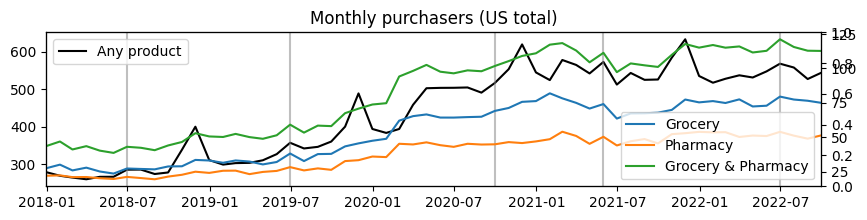

In [35]:
fig, ax = plt.subplots(1,1,figsize=(10,2))
ax.set_xlim(us_monthly_ps.index[0], us_monthly_ps.index[-1])
ax.plot(us_monthly_ps, label='Any product', color='black')
ax2 = ax.twinx()
ax2.plot(us_monthly_groc_ps, label='Grocery')
ax3 = ax.twinx()
ax2.plot(us_monthly_pharm_ps, label='Pharmacy')
ax2.plot(us_monthly_groc_pharm_ps, label='Grocery & Pharmacy')
for d in amzn_prime_months: ax.axvline(d, color='gray', alpha=0.5)
_ = ax.legend()
_ = ax2.legend(loc='lower right')
_ = ax.set_title('Monthly purchasers (US total)')

Make basic comparison with entire US -- Grocery mobility data

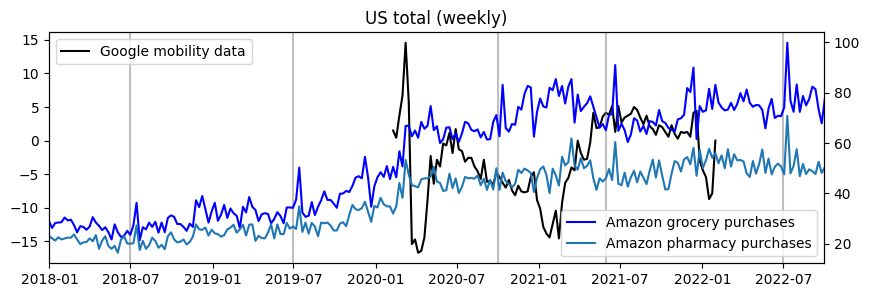

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(grocery_weekly['US'], label='Google mobility data', color='black')
ax.set_xlim(us_weekly_groc_ps.index[0], us_monthly_groc_ps.index[-1])
ax2 = ax.twinx()
ax2.plot(us_weekly_groc_ps, label='Amazon grocery purchases', color='blue')
ax2.plot(us_weekly_pharm_ps, label='Amazon pharmacy purchases')
for d in amzn_prime_months: ax.axvline(d, color='gray', alpha=0.5)
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
_ = ax.set_title('US total (weekly)')

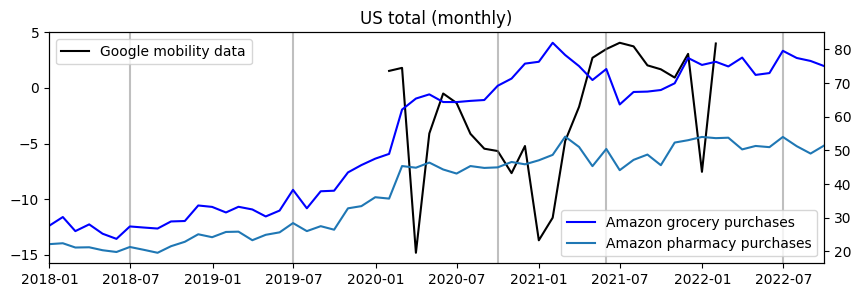

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
ax.plot(grocery_monthly['US'], label='Google mobility data', color='black')
ax.set_xlim(us_monthly_groc_ps.index[0], us_monthly_groc_ps.index[-1])
ax2 = ax.twinx()
ax2.plot(us_monthly_groc_ps, label='Amazon grocery purchases', color='blue')
ax2.plot(us_monthly_pharm_ps, label='Amazon pharmacy purchases')
for d in amzn_prime_months: ax.axvline(d, color='gray', alpha=0.5)
ax.legend()
ax2.legend(loc='lower right')
_ = ax.set_title('US total (monthly)')

### Specific to NY

Plot NY totals

In [38]:
ny_monthly_groc_ps = get_purchasers(amzn_data, state='NY', categories=groc_cats, period='M')
ny_weekly_groc_ps = get_purchasers(amzn_data, state='NY', categories=groc_cats, period='W')

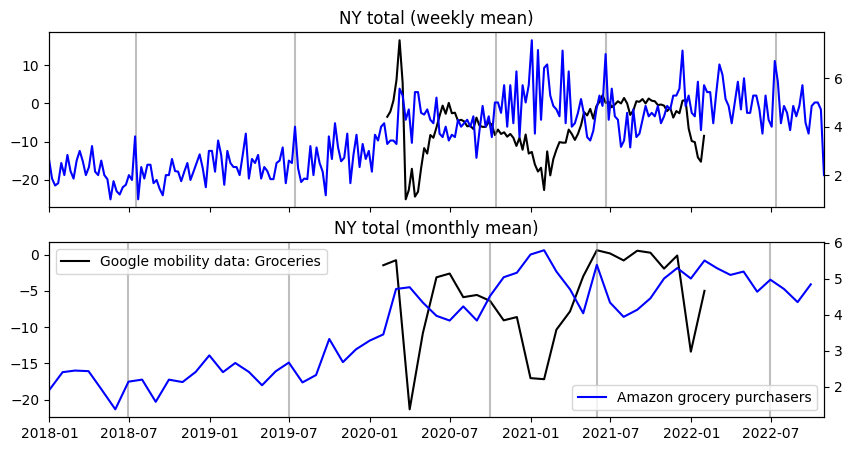

In [39]:
fig, (axw,axm) = plt.subplots(2,1,figsize=(10,5), sharex=True)
axw.set_title('NY total (weekly mean)')
axm.set_title('NY total (monthly mean)')
axw.set_xlim(ny_weekly_groc_ps.index[0], ny_weekly_groc_ps.index[-1])
axw.plot(grocery_weekly['NY'], label='Google mobility data: Groceries', color='black')
axm.plot(grocery_monthly['NY'], label='Google mobility data: Groceries', color='black')
for d in amzn_prime_dates: axw.axvline(d, color='gray', alpha=0.5)
for d in amzn_prime_months: axm.axvline(d, color='gray', alpha=0.5)
axw2 = axw.twinx()
axm2 = axm.twinx()
axw2.plot(ny_weekly_groc_ps, label='Amazon grocery purchasers', color='blue')
axm2.plot(ny_monthly_groc_ps, label='Amazon grocery purchasers', color='blue')
axm.legend()
_ = axm2.legend(loc='lower right')

Should beware of the Amazon prime days inflating spending. 

Also neither of these timeseries are seasonally adjusted.

In [40]:
print('%s months ranging from %s to %s' % (
    len(grocery_monthly), grocery_monthly.index.min(), grocery_monthly.index.max()))
grocery_monthly.head(3)

25 months ranging from 2020-01-31 00:00:00 to 2022-01-31 00:00:00


US        AL        AK         AZ        AR         CA   
date                                                                        
2020-01-31   1.533333  1.666667  2.400000   2.133333  2.333333   1.266667  \
2020-02-29   1.806452  6.387097  1.741935   2.354839  5.548387  -1.000000   
2020-03-31 -14.833333 -6.000000 -9.866667 -14.900000 -1.433333 -18.233333   

                   CO         CT         DE         DC  ...        SD   
date                                                    ...             
2020-01-31   2.266667  -1.200000   1.600000  -3.866667  ...  6.866667  \
2020-02-29   1.548387   0.774194  -3.096774  -9.258065  ...  9.741935   
2020-03-31 -19.266667 -19.200000 -20.466667 -32.500000  ... -2.866667   

                  TN         TX         UT         VT         VA         WA   
date                                                                          
2020-01-31  1.666667   2.533333   8.333333   1.600000   1.866667   1.866667  \
2020-02-29  6.161290   2.935484  10.258065  -5.774194   1.645161  -1.516129   
2020-03-31 -6.366667 -15.033333  -9.400000 -26.600000 -14.400000 -14.066667   

                   WV         WI        WY  
date                                        
2020-01-31  -0.666667   2.866667  5.800000  
2020-02-29   0.967742  -0.935484  8.419355  
2020-03-31 -11.033333 -14.966667 -7.200000  

[3 rows x 52 columns]

In [41]:
# Drop december
mod_grocery_monthly = grocery_monthly.drop(['2020-11-30', '2021-11-30'])
print('%s months after dropping Decembers' % len(mod_grocery_monthly))
# It's not necessary to drop Amazon prime months
# mod_grocery_monthly = mod_grocery_monthly.drop(['2020-10-31', '2021-06-30'])
# print('%s months after dropping prime months' % len(mod_grocery_monthly))
mod_grocery_monthly.head(3)

23 months after dropping Decembers


US        AL        AK         AZ        AR         CA   
date                                                                        
2020-01-31   1.533333  1.666667  2.400000   2.133333  2.333333   1.266667  \
2020-02-29   1.806452  6.387097  1.741935   2.354839  5.548387  -1.000000   
2020-03-31 -14.833333 -6.000000 -9.866667 -14.900000 -1.433333 -18.233333   

                   CO         CT         DE         DC  ...        SD   
date                                                    ...             
2020-01-31   2.266667  -1.200000   1.600000  -3.866667  ...  6.866667  \
2020-02-29   1.548387   0.774194  -3.096774  -9.258065  ...  9.741935   
2020-03-31 -19.266667 -19.200000 -20.466667 -32.500000  ... -2.866667   

                  TN         TX         UT         VT         VA         WA   
date                                                                          
2020-01-31  1.666667   2.533333   8.333333   1.600000   1.866667   1.866667  \
2020-02-29  6.161290   2.935484  10.258065  -5.774194   1.645161  -1.516129   
2020-03-31 -6.366667 -15.033333  -9.400000 -26.600000 -14.400000 -14.066667   

                   WV         WI        WY  
date                                        
2020-01-31  -0.666667   2.866667  5.800000  
2020-02-29   0.967742  -0.935484  8.419355  
2020-03-31 -11.033333 -14.966667 -7.200000  

[3 rows x 52 columns]

In [42]:
mod_ny_monthly_groc_ps = ny_monthly_groc_ps.reindex(mod_grocery_monthly.index)

Modified to skip December months
Pearson r=-0.513; p=0.0122
Spearman r=-0.415; p=0.0490


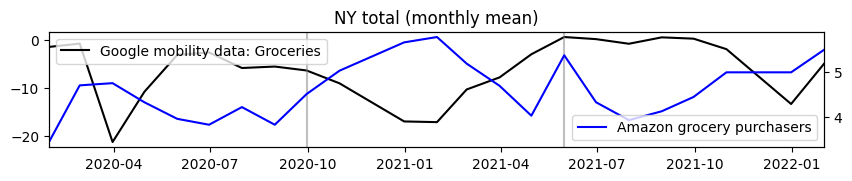

In [43]:
print('Modified to skip December months')
fig, ax = plt.subplots(1,1,figsize=(10,1.5))
ax.plot(mod_grocery_monthly['NY'], label='Google mobility data: Groceries', color='black')
ax.set_xlim(mod_ny_monthly_groc_ps.index[0], mod_ny_monthly_groc_ps.index[-1])
for d in amzn_prime_months: ax.axvline(d, color='gray', alpha=0.5)
ax2 = ax.twinx()
ax2.plot(mod_ny_monthly_groc_ps, label='Amazon grocery purchasers', color='blue')
ax.legend(loc='upper left')
ax2.legend(loc='lower right')
_ = ax.set_title('NY total (monthly mean)')

r, pvalue = pearsonr(mod_ny_monthly_groc_ps, mod_grocery_monthly['NY'])
print('Pearson r=%0.3f; p=%0.4f' % (r, pvalue))
r, pvalue = spearmanr(mod_ny_monthly_groc_ps, mod_grocery_monthly['NY'])
print('Spearman r=%0.3f; p=%0.4f' % (r, pvalue))

### More states

Make tables for weekly and monthly timeseries, where each column is a state.

In [44]:
amzn_groc_ps_weekly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, categories=groc_cats, period='W') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
amzn_groc_ps_weekly.head(3)

AL   AK        AZ   AR        CA   CO   CT   DE   DC        FL   
Order Date                                                                    
2017-12-31  0.0  0.0  1.250000  1.0  3.428571  1.0  0.0  0.0  0.0  2.000000  \
2018-01-07  1.0  0.0  1.333333  1.0  2.714286  1.0  1.0  1.0  0.0  1.666667   
2018-01-14  1.0  0.0  1.000000  1.0  3.142857  1.0  1.0  1.0  0.0  2.800000   

            ...   SD   TN        TX   UT   VT        VA        WA   WV   
Order Date  ...                                                          
2017-12-31  ...  0.0  1.0  2.166667  1.0  1.0  2.000000  1.666667  0.0  \
2018-01-07  ...  0.0  0.0  1.857143  0.0  0.0  1.142857  1.666667  1.0   
2018-01-14  ...  0.0  1.0  1.857143  0.0  0.0  1.400000  1.600000  1.0   

                  WI   WY  
Order Date                 
2017-12-31  1.200000  0.0  
2018-01-07  1.333333  0.0  
2018-01-14  1.000000  1.0  

[3 rows x 51 columns]

In [45]:
amzn_groc_ps_monthly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, categories=groc_cats, period='M') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
amzn_groc_ps_monthly.head(3)

AL   AK   AZ     AR        CA        CO   CT   DE   DC        FL   
Order Date                                                                      
2017-12-31  1.0  0.0  1.2  1.125  3.275862  1.100000  1.0  1.0  1.0  2.083333  \
2018-01-31  1.0  0.0  1.0  1.000  2.888889  1.125000  1.0  1.0  1.0  2.607143   
2018-02-28  1.2  0.0  1.0  1.000  2.600000  1.181818  1.0  2.0  1.0  1.958333   

            ...   SD        TN        TX   UT   VT        VA        WA   WV   
Order Date  ...                                                               
2017-12-31  ...  0.0  1.222222  1.964286  1.0  1.0  1.380952  1.750000  1.0  \
2018-01-31  ...  1.0  1.400000  2.360000  1.0  1.0  1.400000  1.473684  1.0   
2018-02-28  ...  0.0  1.153846  2.115385  1.0  1.0  1.500000  1.545455  1.2   

                  WI   WY  
Order Date                 
2017-12-31  1.266667  1.0  
2018-01-31  1.500000  0.0  
2018-02-28  1.500000  0.0  

[3 rows x 51 columns]

In [46]:
# Make a modified version for correlation inspection
mod_amzn_groc_ps_monthly = amzn_groc_ps_monthly.reindex(mod_grocery_monthly.index)

Do the same for pharmacy purchases

In [47]:
amzn_pharm_ps_weekly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, categories=pharmacy_cats, period='W') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
amzn_pharm_ps_monthly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, categories=pharmacy_cats, period='M') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
amzn_pharm_ps_monthly.head(3)

AL   AK        AZ        AR        CA   CO   CT   DE   DC   
Order Date                                                                    
2017-12-31  1.000000  1.0  1.111111  1.000000  3.000000  1.0  1.0  1.0  1.2  \
2018-01-31  1.285714  0.0  1.142857  1.000000  2.458333  1.0  1.2  1.0  1.0   
2018-02-28  1.200000  1.0  1.000000  1.333333  2.290323  1.0  1.6  1.0  1.0   

                  FL  ...   SD        TN        TX   UT   VT        VA   
Order Date            ...                                                
2017-12-31  1.653846  ...  0.0  1.166667  1.739130  1.0  1.0  1.333333  \
2018-01-31  2.166667  ...  1.0  1.500000  2.454545  1.0  1.0  1.461538   
2018-02-28  1.695652  ...  1.0  1.222222  2.040000  1.0  1.0  1.315789   

                  WA    WV        WI   WY  
Order Date                                 
2017-12-31  1.333333  1.00  1.181818  0.0  
2018-01-31  1.500000  1.00  1.142857  0.0  
2018-02-28  1.473684  1.25  1.181818  0.0  

[3 rows x 51 columns]

In [48]:
# Make a modified version for correlation inspection
mod_amzn_pharm_ps_monthly = amzn_pharm_ps_monthly.reindex(mod_grocery_monthly.index)

Do the same for the combined grocery + pharmacy categories

In [49]:
amzn_groc_pharm_ps_weekly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, categories=groc_pharm_cats, period='W') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
amzn_groc_pharm_ps_monthly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, categories=groc_pharm_cats, period='M') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
# Make a modified version for correlation inspection
mod_amzn_groc_pharm_ps_monthly = amzn_groc_pharm_ps_monthly.reindex(mod_grocery_monthly.index)
amzn_groc_pharm_ps_monthly.head(3)

AL   AK        AZ        AR        CA        CO        CT   
Order Date                                                                    
2017-12-31  1.166667  1.0  1.200000  1.166667  5.200000  1.181818  1.076923  \
2018-01-31  1.222222  0.0  1.181818  1.166667  4.500000  1.153846  1.100000   
2018-02-28  1.250000  1.0  1.071429  1.111111  4.258065  1.294118  1.555556   

             DE        DC        FL  ...   SD        TN        TX   UT   VT   
Order Date                           ...                                      
2017-12-31  1.0  1.166667  2.709677  ...  0.0  1.333333  2.900000  1.0  1.0  \
2018-01-31  1.0  1.000000  3.607143  ...  1.0  1.750000  3.740741  1.0  1.0   
2018-02-28  1.5  1.000000  2.533333  ...  1.0  1.222222  2.933333  1.0  1.0   

                  VA        WA        WV        WI   WY  
Order Date                                               
2017-12-31  1.851852  2.000000  1.000000  1.476190  1.0  
2018-01-31  1.791667  1.772727  1.166667  1.600000  0.0  
2018-02-28  1.925926  2.000000  1.250000  1.444444  0.0  

[3 rows x 51 columns]

In [50]:
def plot_weekly_monthly_groc(state, ax=None, pharmacy=False):
    if ax is None: fig, (axw,axm) = plt.subplots(2,1,figsize=(10,4), sharex=True)
    axw.set_title('%s (weekly mean)'%state)
    axm.set_title('%s (monthly mean)'%state)
    axw.set_xlim(amzn_groc_ps_weekly.index[0], amzn_groc_ps_weekly.index[-1])
    axw.plot(grocery_weekly[state], label='Google mobility reports: Grocery', color='black')
    axm.plot(grocery_monthly[state], label='Google mobility reports: Grocery', color='black')
    for d in amzn_prime_dates: axw.axvline(d, color='gray', alpha=0.5)
    for d in amzn_prime_months: axm.axvline(d, color='gray', alpha=0.5)
    axw2 = axw.twinx()
    axm2 = axm.twinx()
    axw2.plot(amzn_groc_ps_weekly[state], label='Amazon grocery purchasers', color='blue')
    axm2.plot(amzn_groc_ps_monthly[state], label='Amazon grocery purchasers', color='blue')
    if pharmacy:
        axw2.plot(amzn_pharm_ps_weekly[state], label='Amazon pharmacy purchasers')
        axm2.plot(amzn_pharm_ps_monthly[state], label='Amazon pharmacy purchasers')
    axm.legend(loc='upper left')
    axm2.legend(loc='lower right')
    return ax

#### CA

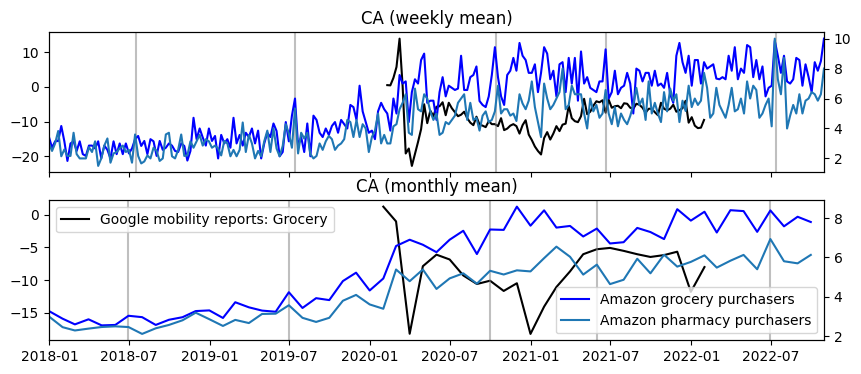

In [51]:
ax = plot_weekly_monthly_groc('CA', pharmacy=True)

In [53]:
def get_monthly_groc_pharm_correlation(state, plot=True, ax=None):
    print('Correlation between months, modified to skip December months')
    r, pvalue = pearsonr(mod_amzn_groc_pharm_ps_monthly[state], mod_grocery_monthly[state])
    print('Pearson r=%0.3f; p=%0.4f' % (r, pvalue))
    r, pvalue = spearmanr(mod_amzn_groc_pharm_ps_monthly[state], mod_grocery_monthly[state])
    print('Spearman r=%0.3f; p=%0.4f' % (r, pvalue))
    if plot:
        if ax is None: fig, ax = plt.subplots(1,1,figsize=(10,1))
        ax.plot(grocery_monthly[state], label='Google mobility data', color='black')
        ax.set_xlim(grocery_monthly.index[0], grocery_monthly.index[-1])
        ax2 = ax.twinx()
        ax2.plot(amzn_groc_pharm_ps_monthly[state], label='Amazon grocery & pharmacy purchasers', color='blue')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')
        ax.set_title('%s (monthly mean)'%state)
        return ax

In [54]:
def get_monthly_pharm_correlation(state, plot=True, ax=None):
    print('Correlation between months, modified to skip December months')
    r, pvalue = pearsonr(mod_amzn_pharm_ps_monthly[state], mod_grocery_monthly[state])
    print('Pearson r=%0.3f; p=%0.4f' % (r, pvalue))
    r, pvalue = spearmanr(mod_amzn_pharm_ps_monthly[state], mod_grocery_monthly[state])
    print('Spearman r=%0.3f; p=%0.4f' % (r, pvalue))
    if plot:
        if ax is None: fig, ax = plt.subplots(1,1,figsize=(10,1))
        ax.plot(mod_grocery_monthly[state], label='Google mobility data', color='black')
        ax.set_xlim(mod_amzn_pharm_ps_monthly.index[0], mod_amzn_groc_ps_monthly.index[-1])
        ax2 = ax.twinx()
        ax2.plot(mod_amzn_pharm_ps_monthly[state], label='Amazon pharmacy purchasers', color='blue')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')
        ax.set_title('%s (monthly mean)'%state)
        return ax

In [70]:
tight_dots = (0, (1,1)) # densely dotted

def get_monthly_groc_correlation(state, plot=True, ax=None, legend=True, title=True):
    print('%s: Correlation between months, skipping December months' % state)
    r, pvalue = pearsonr(mod_amzn_groc_ps_monthly[state], mod_grocery_monthly[state])
    print('Pearson r=%0.3f; p=%0.4f' % (r, pvalue))
    r, pvalue = spearmanr(mod_amzn_groc_ps_monthly[state], mod_grocery_monthly[state])
    print('Spearman r=%0.3f; p=%0.4f' % (r, pvalue))
    if plot:
        if ax is None: fig, ax = plt.subplots(1,1,figsize=(10,1))
        ax.plot(grocery_monthly[state], linestyle='-', label='Google mobility data', color='black')
        ax.set_xlim(grocery_monthly.index[0], grocery_monthly.index[-1])
        ax2 = ax.twinx()
        ax2.plot(amzn_groc_ps_monthly[state], linestyle=tight_dots, label='Amazon grocery purchasers', color='black')
        if legend: ax.legend(loc='upper left')
        if legend: ax2.legend(loc='lower right')
        if title: ax.set_title('%s (monthly mean)'%state)
        return ax

CA: Correlation between months, skipping December months
Pearson r=-0.544; p=0.0073
Spearman r=-0.541; p=0.0077


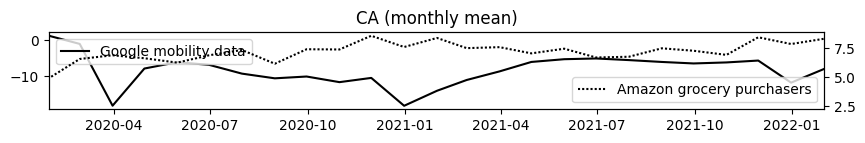

In [72]:
ax = get_monthly_groc_correlation('CA')

Correlation between months, modified to skip December months
Pearson r=-0.305; p=0.1565
Spearman r=-0.259; p=0.2336


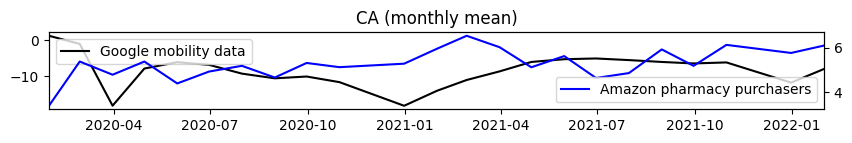

In [73]:
ax = get_monthly_pharm_correlation('CA')

Correlation between months, modified to skip December months
Pearson r=-0.456; p=0.0288
Spearman r=-0.402; p=0.0574


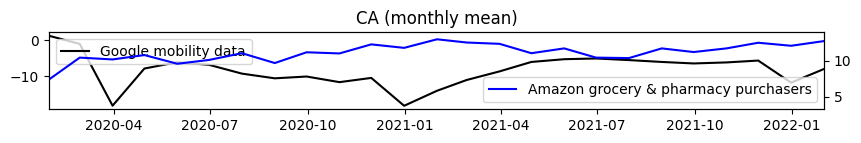

In [74]:
ax = get_monthly_groc_pharm_correlation('CA')

---

### Notes

- There is not a significant correlation if the states are mismatched!
    - i.e. Google NY timeseries doesn't correlation with CA Amazon timeseries
    - is this nice validation?
    
- FL likely impacted by seasonal travel: More people traveling in likely increases both Amazon and in-store purchases
    - perhaps similarly for other states with seasonal populations (PA for college towns?)
    

---

What are the states where there are sufficient purchasers?

In [75]:
amzn_data.groupby(STATE)[RESPONSE_ID].nunique().sort_values(ascending=False).head()

Shipping Address State
CA    907
FL    741
TX    723
NY    585
PA    518
Name: Survey ResponseID, dtype: int64

In [76]:
amzn_groc_ps_monthly.max().sort_values(ascending=False).head()

CA    8.580645
TX    5.833333
NY    5.785714
FL    5.612903
PA    5.290323
dtype: float64

In [101]:
amzn_groc_ps_monthly.mean().sort_values(ascending=False).head()

CA    5.654301
TX    4.090994
NY    3.699743
FL    3.432987
PA    3.409486
dtype: float64

### Results localization

In the 23 months prior to the months when the Google mobility data is available 
(2018-03 to 2020-01), which were impacted by COVID,
the Amazon grocery purchases between states were highly correlated. 
Pearson r=0.708, r=0.715, r=0.878.

In [77]:
amzn_groc_ps_monthly[:'2020-01-31'][-23:][['CA', 'TX', 'NY']].corr().round(3)

CA     TX     NY
CA  1.000  0.889  0.781
TX  0.889  1.000  0.796
NY  0.781  0.796  1.000

In the 23 months when the Google mobility data is available (2020-02 to 2022-02) the Amazon purchases data between states were much less correlated.

Pearson r=0.31, r=0.473, r=0.769

This shows how the COVID related behavior changes that yielded statistically significant negative correlations, indicative of substitution effects, between the mobility data and purchases data on the state level, are specific to behavior changes in those states.

In [87]:
print('%s months of google mobility data' % len(mod_amzn_groc_ps_monthly.index))
mod_amzn_groc_ps_monthly[['CA', 'TX', 'NY']].corr().round(3)

23 months of google mobility data


CA     TX     NY
CA  1.000  0.473  0.769
TX  0.473  1.000  0.307
NY  0.769  0.307  1.000

In [82]:
print('All months prior to Google mobility data availability')
amzn_groc_ps_monthly[:'2020-01-31'][['CA', 'TX', 'NY']].corr().round(3)

All months prior to Google mobility data availability


CA     TX     NY
CA  1.000  0.877  0.743
TX  0.877  1.000  0.780
NY  0.743  0.780  1.000

### Make plots for the monthly values for the 3 top states

CA: Correlation between months, skipping December months
Pearson r=-0.544; p=0.0073
Spearman r=-0.541; p=0.0077
TX: Correlation between months, skipping December months
Pearson r=-0.431; p=0.0399
Spearman r=-0.453; p=0.0301
NY: Correlation between months, skipping December months
Pearson r=-0.513; p=0.0122
Spearman r=-0.415; p=0.0490


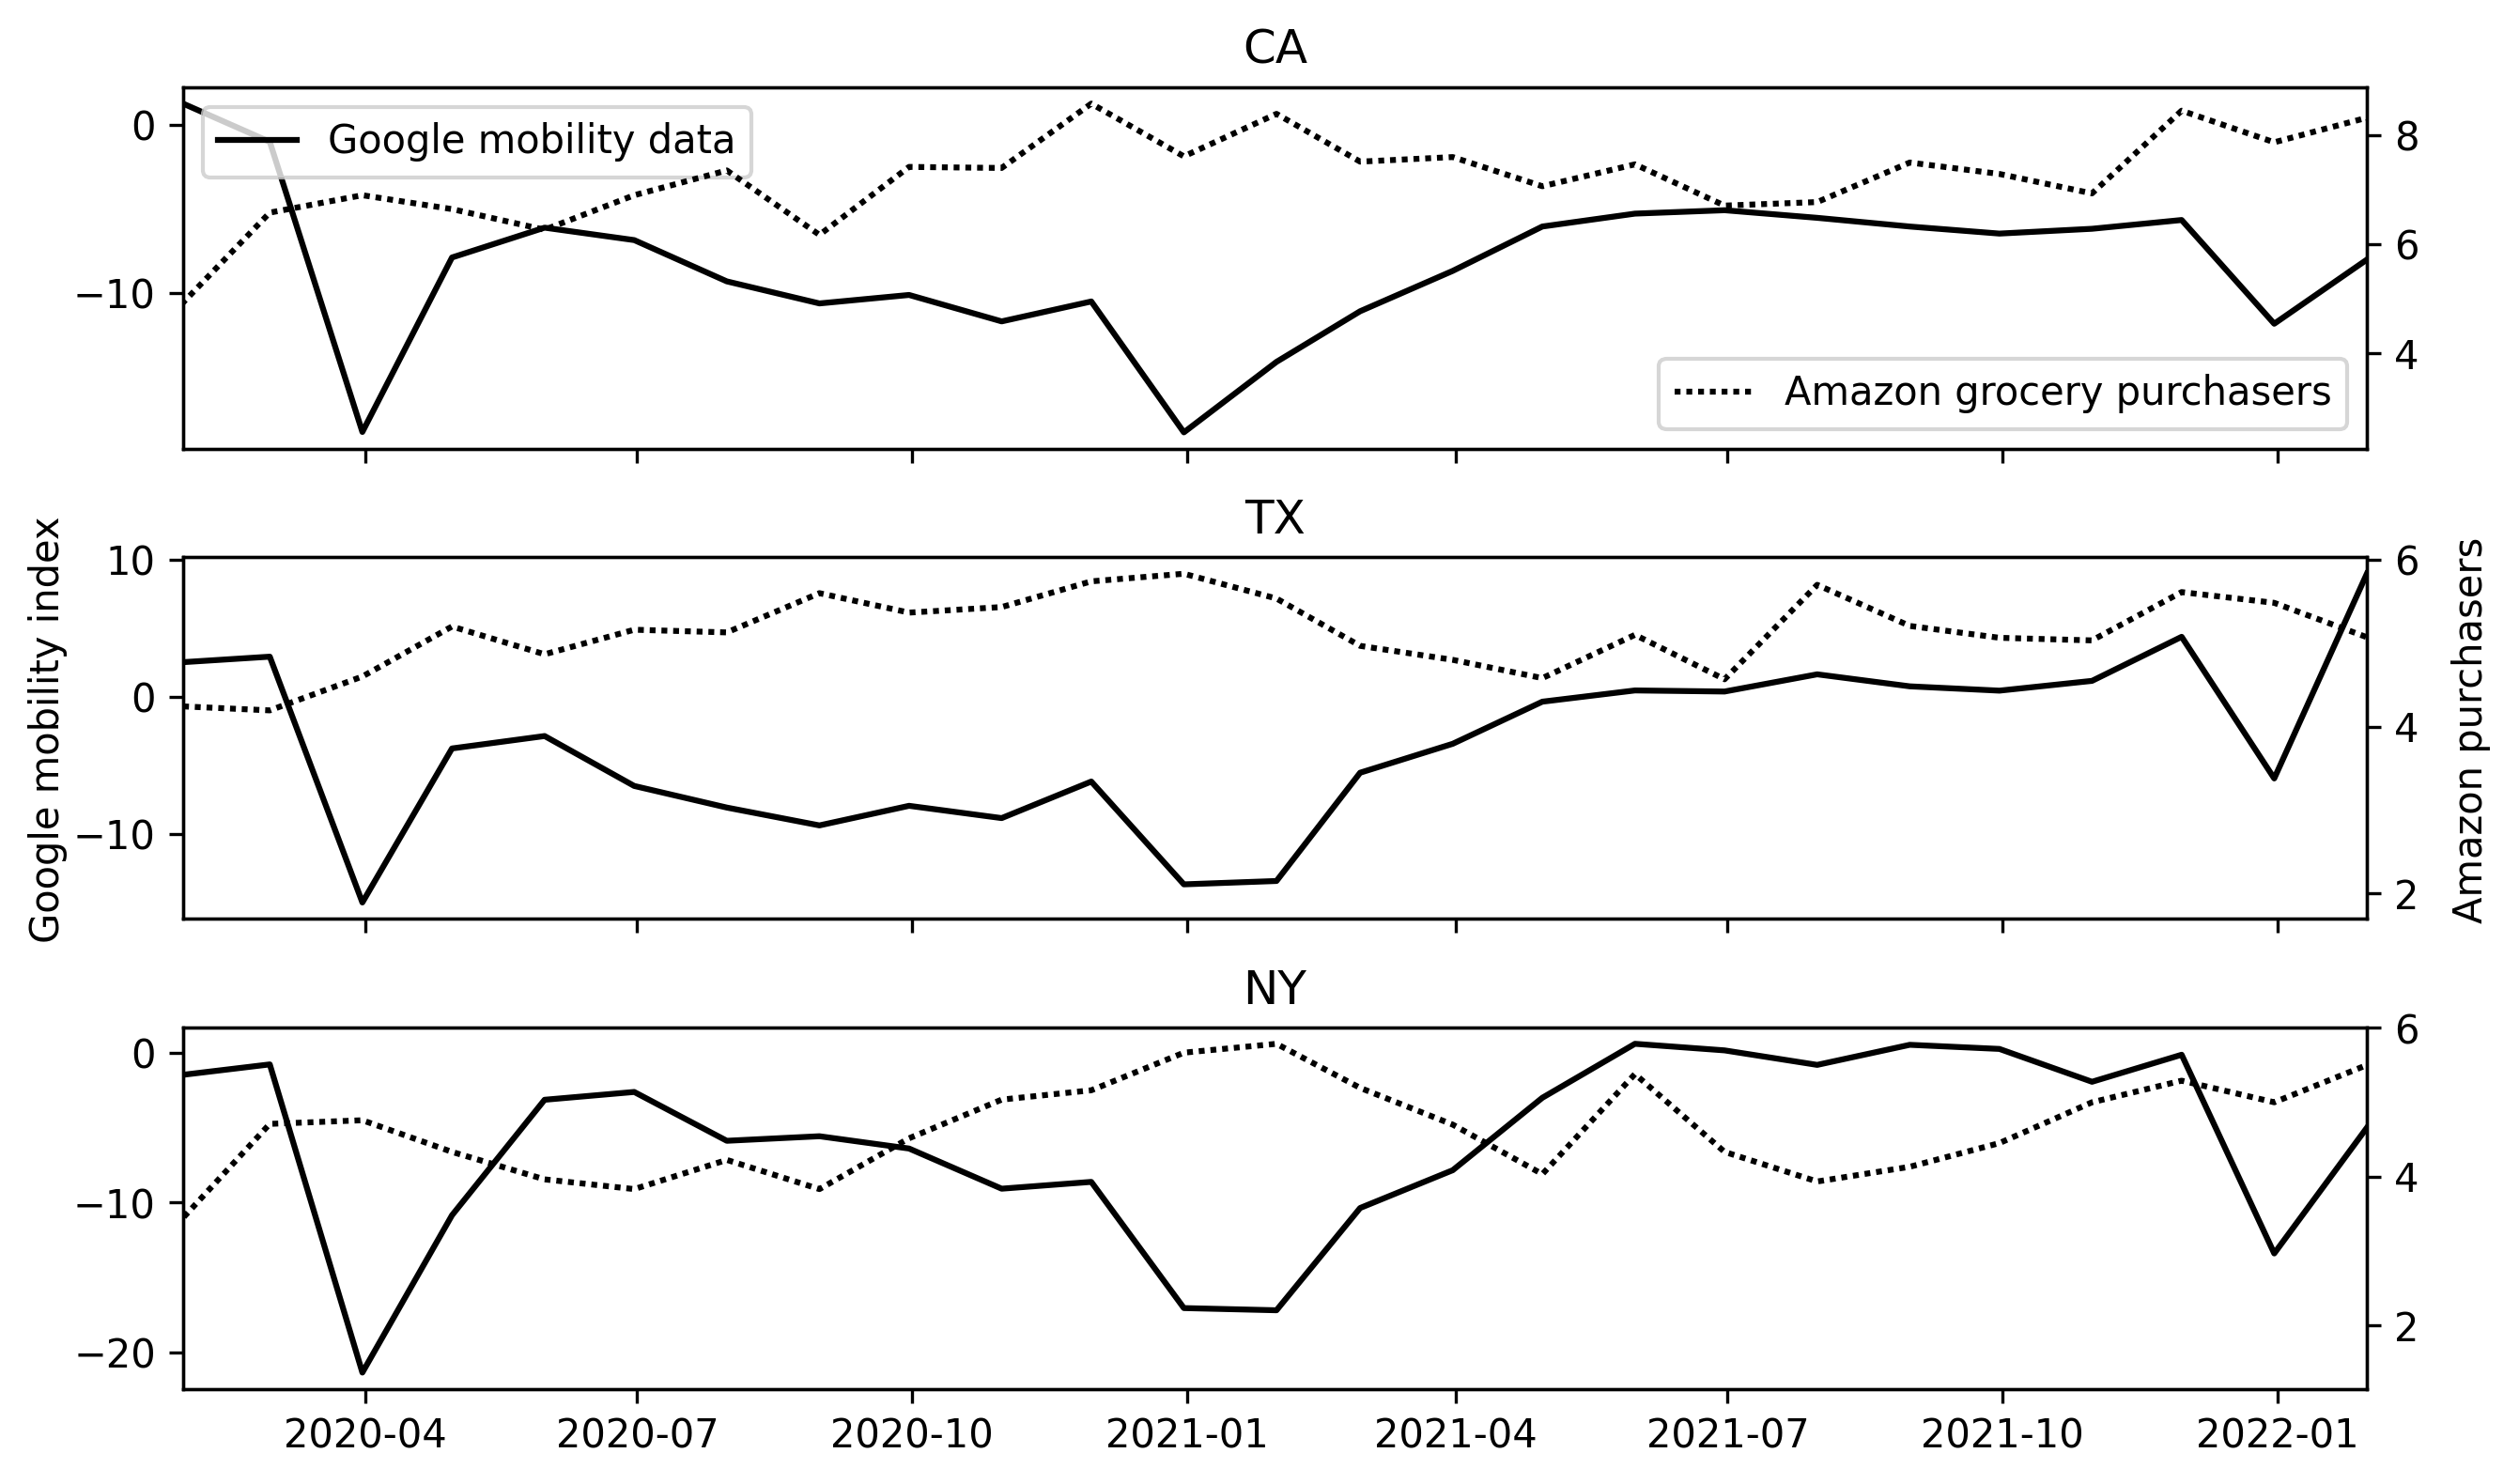

In [79]:
fig, (ax_ca, ax_tx, ax_ny) = plt.subplots(3, 1, figsize=(10, 6), sharex=True, dpi=300)
fig.subplots_adjust(hspace=0.3)
# plt.tight_layout()
_ = get_monthly_groc_correlation('CA', plot=True, ax=ax_ca, legend=True, title=False)
_ = get_monthly_groc_correlation('TX', plot=True, ax=ax_tx, legend=False, title=False)
_ = get_monthly_groc_correlation('NY', plot=True, ax=ax_ny, legend=False, title=False)
ax_ca.set_title('CA')
ax_tx.set_title('TX')
ax_ny.set_title('NY')
# a problem with these plots is that they
_ = fig.text(0.07, 0.5, 'Google mobility index', va='center', rotation=90, fontsize='medium')
_ = fig.text(0.93, 0.5, 'Amazon purchasers', va='center', rotation=90, fontsize='medium')

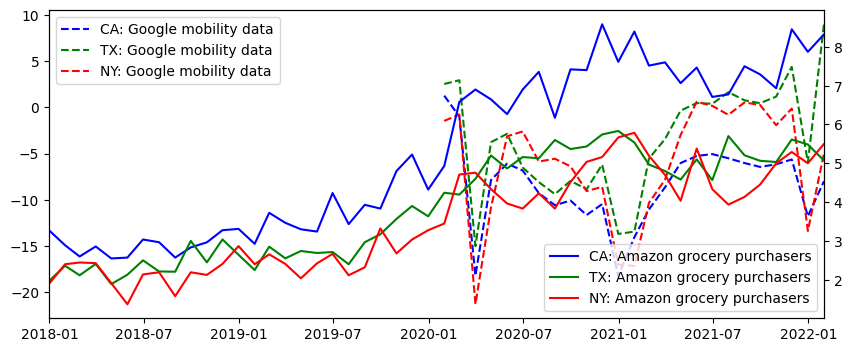

In [81]:
plt_states = ['CA','TX','NY']
colors = ['blue','green','red']
# colors=['tab:orange','tab:blue','purple']
fig, ax_g = plt.subplots(1,1,figsize=(10,4))#, dpi=300)
ax_a = ax_g.twinx()
ax_g.set_xlim(amzn_groc_ps_monthly.index[0], grocery_monthly.index[-1])
for s, state in enumerate(plt_states):
    ax_g.plot(grocery_monthly[state], '--',
              label='%s: Google mobility data'%state, color=colors[s])
    
    ax_a.plot(amzn_groc_ps_monthly[state], 
              label='%s: Amazon grocery purchasers'%state, color=colors[s])
ax_g.legend(loc='upper left')
_ = ax_a.legend(loc='lower right')

#### Other states

The effect weakens as the data quantity declines

CA
CA: Correlation between months, skipping December months
Pearson r=-0.544; p=0.0073
Spearman r=-0.541; p=0.0077


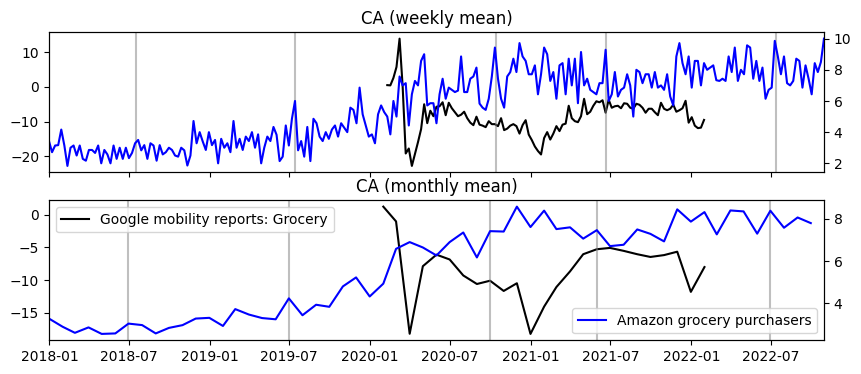

TX
TX: Correlation between months, skipping December months
Pearson r=-0.431; p=0.0399
Spearman r=-0.453; p=0.0301


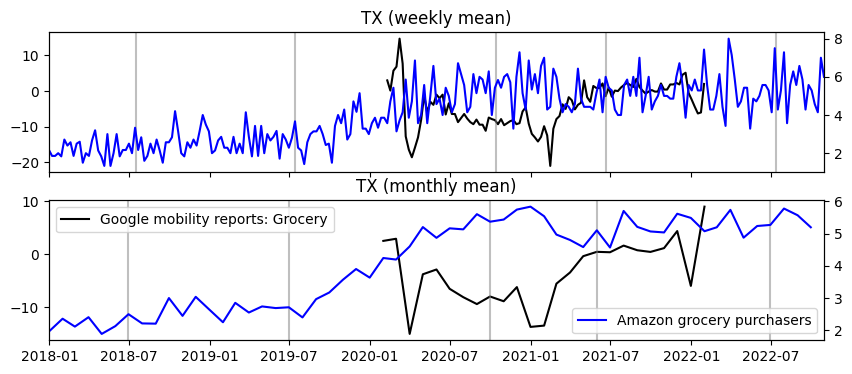

NY
NY: Correlation between months, skipping December months
Pearson r=-0.513; p=0.0122
Spearman r=-0.415; p=0.0490


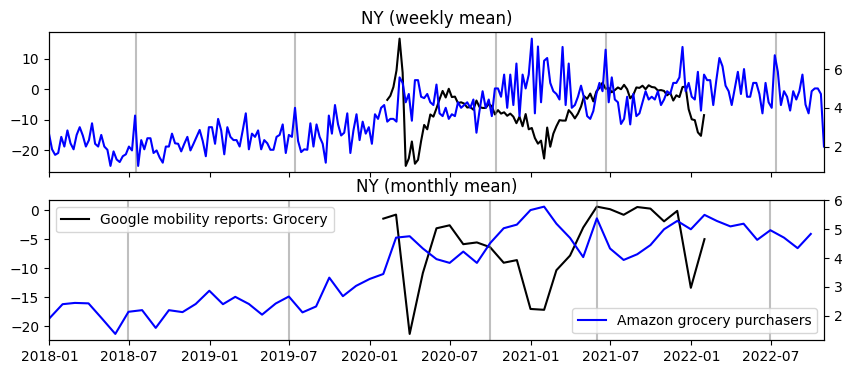

FL
FL: Correlation between months, skipping December months
Pearson r=-0.271; p=0.2116
Spearman r=-0.130; p=0.5530


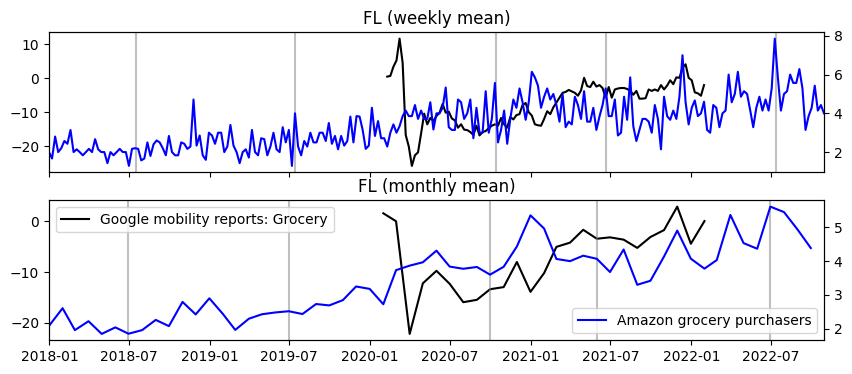

PA
PA: Correlation between months, skipping December months
Pearson r=-0.117; p=0.5944
Spearman r=-0.087; p=0.6931


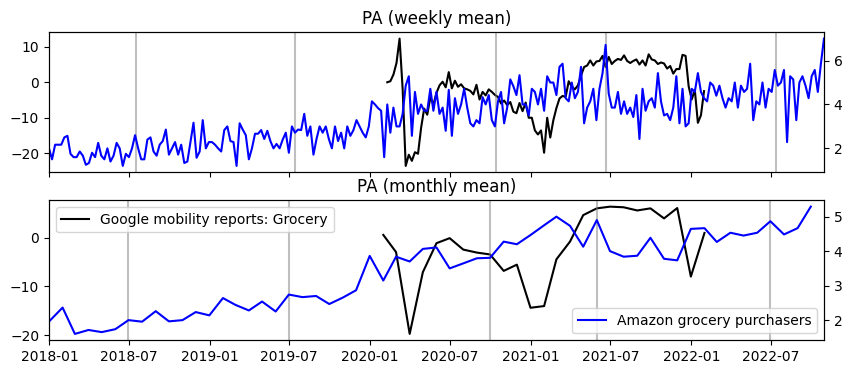

OH
OH: Correlation between months, skipping December months
Pearson r=-0.169; p=0.4401
Spearman r=-0.227; p=0.2973


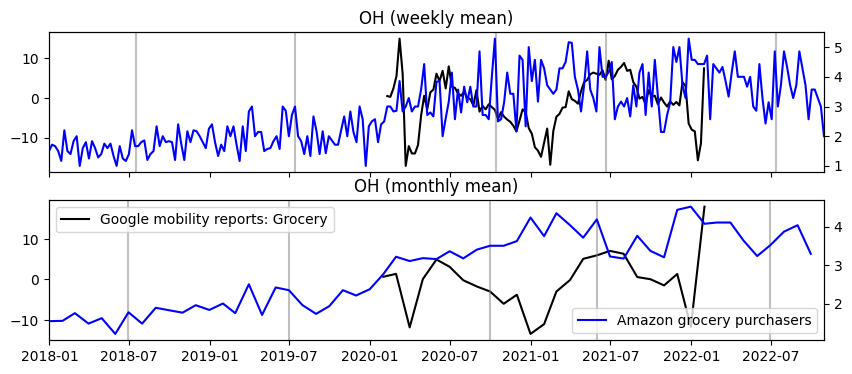

In [80]:
for s, state in enumerate(amzn_groc_ps_monthly.max().sort_values(ascending=False).index):
    if s > 5: break
    print(state)
    ax = plot_weekly_monthly_groc(state)
    ax = get_monthly_groc_correlation(state, plot=False)
    plt.show()

#### Repeat analysis for grocery & pharmacy related producs

Result: This doesn't work

In [203]:
amzn_groc_pharm_ps_monthly.max().sort_values(ascending=False).head()

CA    11.129032
TX     8.033333
FL     7.258065
NY     7.214286
PA     6.806452
dtype: float64

CA
Correlation between months, modified to skip December months
Pearson r=-0.452; p=0.0302
Spearman r=-0.398; p=0.0601


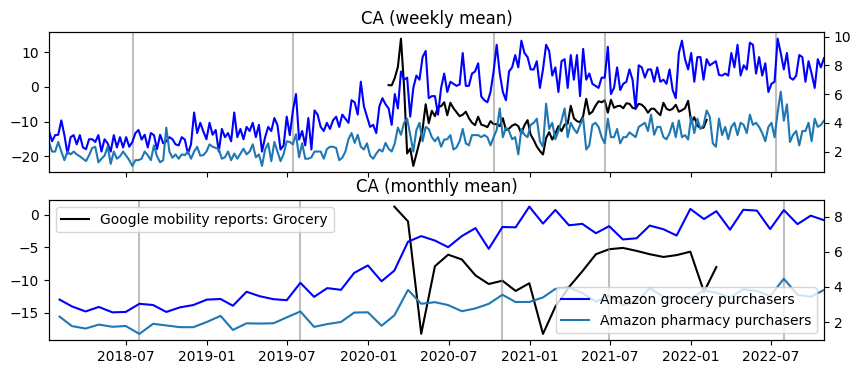

TX
Correlation between months, modified to skip December months
Pearson r=-0.196; p=0.3709
Spearman r=-0.162; p=0.4612


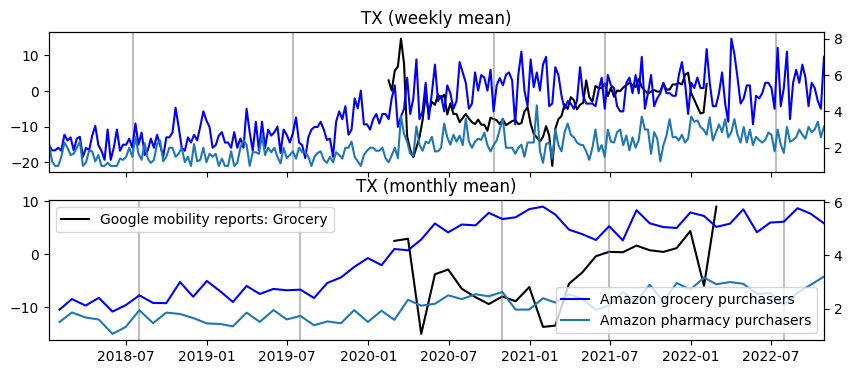

FL
Correlation between months, modified to skip December months
Pearson r=-0.134; p=0.5417
Spearman r=-0.028; p=0.9002


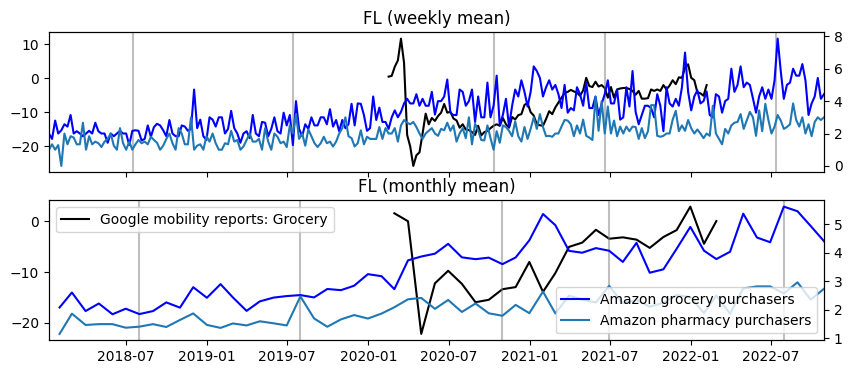

PA
Correlation between months, modified to skip December months
Pearson r=-0.055; p=0.8039
Spearman r=-0.054; p=0.8055


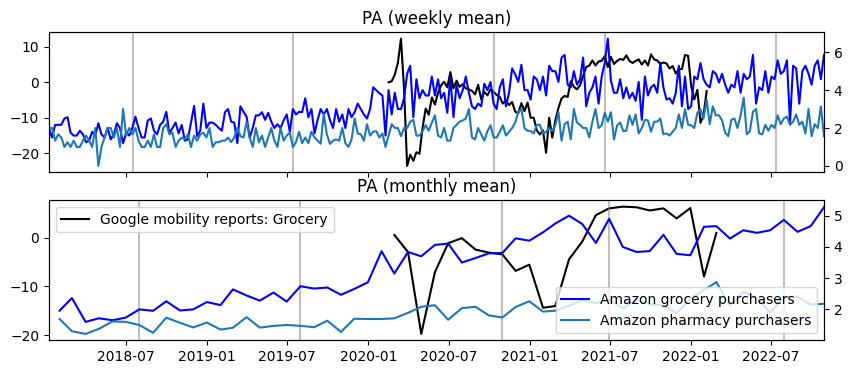

NY
Correlation between months, modified to skip December months
Pearson r=-0.364; p=0.0873
Spearman r=-0.262; p=0.2274


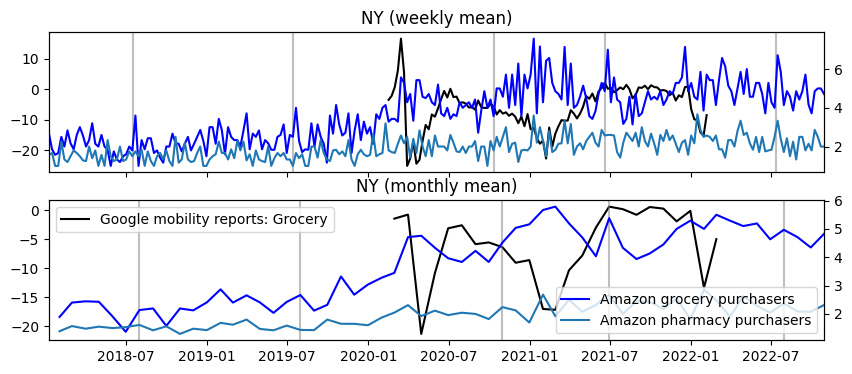

IL
Correlation between months, modified to skip December months
Pearson r=-0.411; p=0.0512
Spearman r=-0.372; p=0.0809


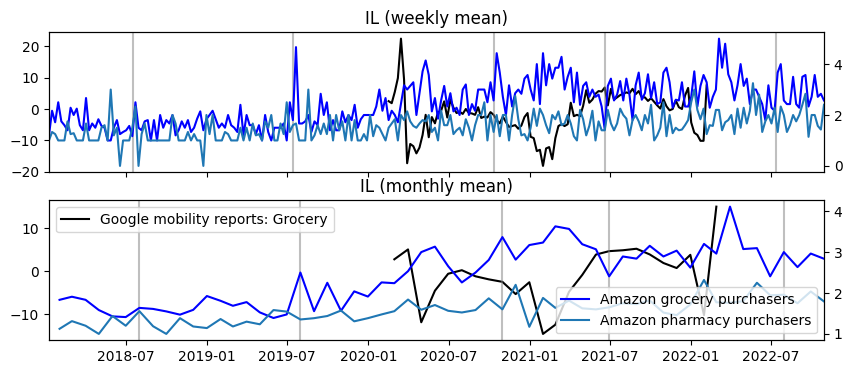

In [204]:
for s, state in enumerate(amzn_pharm_ps_monthly.max().sort_values(ascending=False).index):
    if s > 5: break
    print(state)
    ax = plot_weekly_monthly_groc(state, pharmacy=True)
    ax = get_monthly_groc_pharm_correlation(state, plot=False)
    plt.show()

#### Repeat the analysis for pharmacy related products

In [205]:
amzn_pharm_ps_monthly.max().sort_values(ascending=False).head()

CA    4.466667
TX    3.214286
FL    2.964286
PA    2.875000
NY    2.857143
dtype: float64

CA
Correlation between months, modified to skip December months
Pearson r=-0.233; p=0.2841
Spearman r=-0.211; p=0.3349


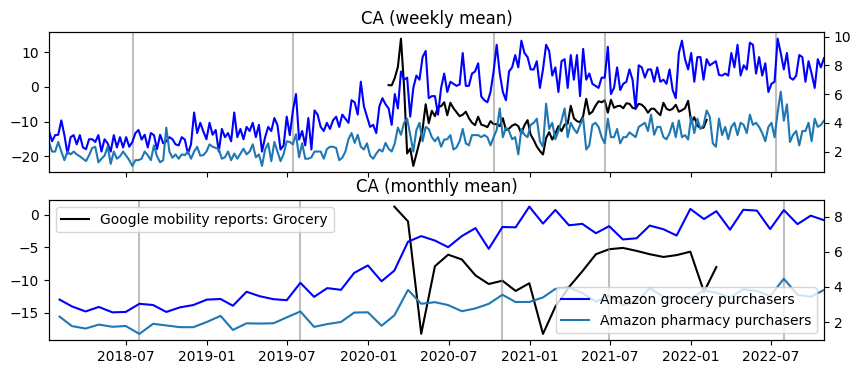

TX
Correlation between months, modified to skip December months
Pearson r=0.134; p=0.5418
Spearman r=0.097; p=0.6603


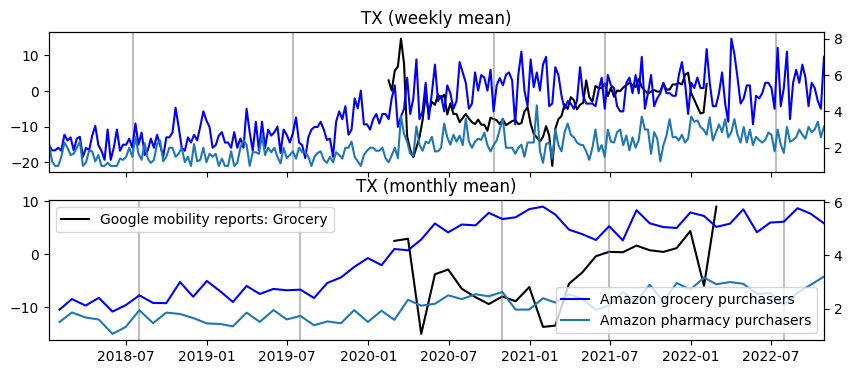

FL
Correlation between months, modified to skip December months
Pearson r=0.265; p=0.2215
Spearman r=0.314; p=0.1441


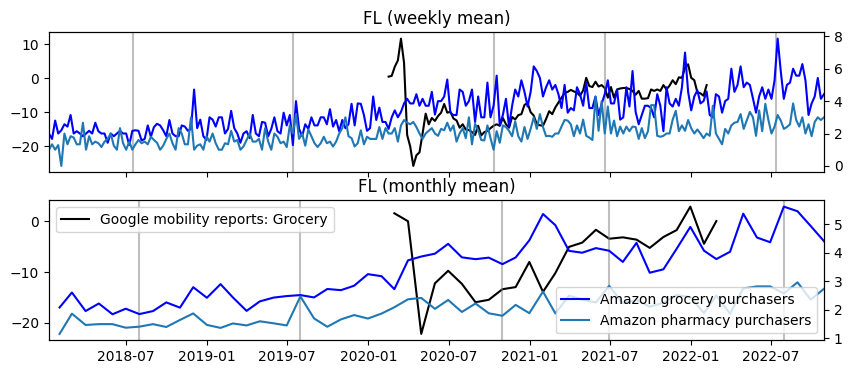

PA
Correlation between months, modified to skip December months
Pearson r=0.134; p=0.5420
Spearman r=0.243; p=0.2636


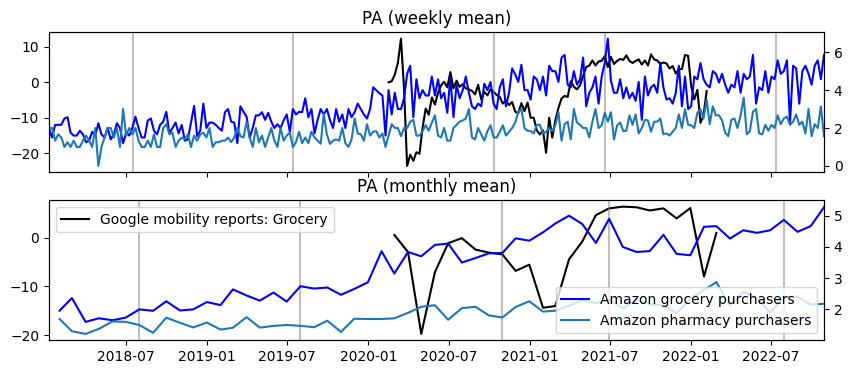

NY
Correlation between months, modified to skip December months
Pearson r=0.052; p=0.8128
Spearman r=0.165; p=0.4516


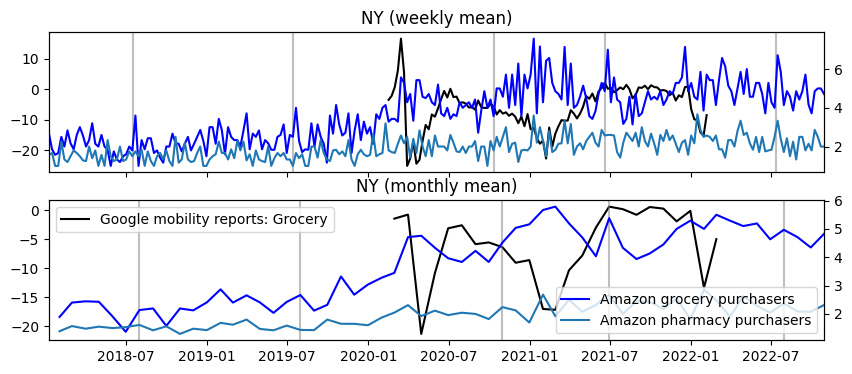

IL
Correlation between months, modified to skip December months
Pearson r=-0.263; p=0.2244
Spearman r=-0.155; p=0.4810


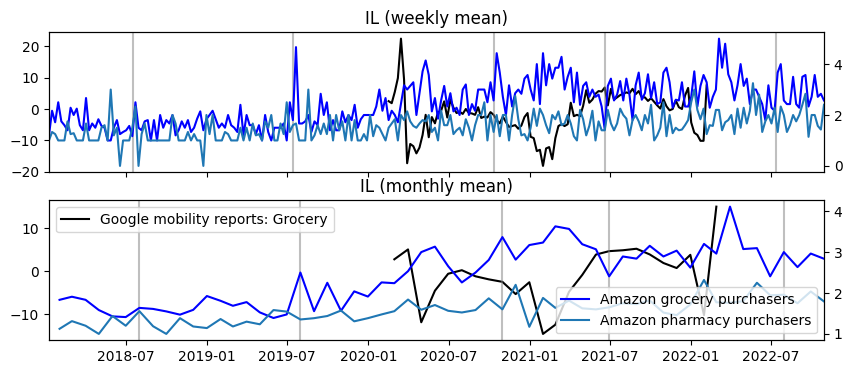

In [206]:
for s, state in enumerate(amzn_pharm_ps_monthly.max().sort_values(ascending=False).index):
    if s > 5: break
    print(state)
    ax = plot_weekly_monthly_groc(state, pharmacy=True)
    ax = get_monthly_pharm_correlation(state, plot=False)
    plt.show()

## Experiments with the Retail and recreation mobility reports data

This doesn't work.

In [113]:
amzn_ps_monthly = pd.DataFrame({
    s_code: get_purchasers(amzn_data, state=s_code, period='M') for s_code in state_codes
}).drop('US', axis=1).fillna(0)
amzn_ps_monthly.head(3)

AL        AK        AZ        AR         CA        CO   
Order Date                                                                
2018-01-31  3.133333  1.222222  3.933333  2.387097  27.903226  4.580645  \
2018-02-28  3.192308  1.200000  3.714286  2.307692  27.714286  3.857143   
2018-03-31  3.103448  1.000000  3.517241  2.566667  27.064516  3.733333   

                  CT        DE        DC         FL  ...        SD        TN   
Order Date                                           ...                       
2018-01-31  3.100000  1.521739  1.870968  15.774194  ...  1.500000  4.387097  \
2018-02-28  2.555556  1.400000  1.583333  16.571429  ...  1.090909  4.750000   
2018-03-31  2.645161  1.428571  2.000000  15.483871  ...  1.133333  4.290323   

                   TX        UT        VT        VA        WA        WV   
Order Date                                                                
2018-01-31  18.870968  2.928571  1.411765  9.903226  7.161290  1.730769  \
2018-02-28  18.607143  3.080000  1.352941  9.107143  6.357143  1.518519   
2018-03-31  19.419355  2.206897  1.285714  8.483871  6.935484  1.888889   

                  WI   WY  
Order Date                 
2018-01-31  5.774194  1.0  
2018-02-28  5.821429  1.0  
2018-03-31  5.741935  1.0  

[3 rows x 51 columns]

In [114]:
def plot_weekly_monthly_retail_vs_amzn(amzn_weekly, amzn_monthly, goog_weekly, goog_monthly, state, ax=None, cat='All products'):
    if ax is None: fig, (axw,axm) = plt.subplots(2,1,figsize=(10,4), sharex=True)
    axw.set_title('%s (weekly mean)'%state)
    axm.set_title('%s (monthly mean)'%state)
    axw.set_xlim(amzn_weekly.index[0], amzn_weekly.index[-1])
    axw.plot(goog_weekly, label='Google mobility reports: Retail and recreation', color='black')
    axm.plot(goog_monthly, label='Google mobility reports: Retail and recreation', color='black')
    for d in amzn_prime_dates: axw.axvline(d, color='gray', alpha=0.5)
    for d in amzn_prime_months: axm.axvline(d, color='gray', alpha=0.5)
    axw2 = axw.twinx()
    axm2 = axm.twinx()
    axw2.plot(amzn_weekly, label='Amazon purchasers: %s'%cat, color='blue')
    axm2.plot(amzn_monthly, label='Amazon purchasers: %s'%cat, color='blue')
    axm.legend(loc='upper left')
    axm2.legend(loc='lower right')
    return ax

Set up correlation analysis

In [115]:
# For comparing months for correlation, dropping Amazon prime day and december months
mod_retail_monthly = grocery_monthly.drop(['2020-10-31', '2021-06-30', '2020-12-31', '2021-12-31'])
print('%s months after dropping Amazon prime and December months' % len(mod_grocery_monthly))
mod_retail_monthly.head(3)

23 months after dropping Amazon prime and December months


US        AL        AK         AZ        AR         CA   
date                                                                        
2020-02-29   1.533333  1.666667  2.400000   2.133333  2.333333   1.266667  \
2020-03-31   1.806452  6.387097  1.741935   2.354839  5.548387  -1.000000   
2020-04-30 -14.833333 -6.000000 -9.866667 -14.900000 -1.433333 -18.233333   

                   CO         CT         DE         DC  ...        SD   
date                                                    ...             
2020-02-29   2.266667  -1.200000   1.600000  -3.866667  ...  6.866667  \
2020-03-31   1.548387   0.774194  -3.096774  -9.258065  ...  9.741935   
2020-04-30 -19.266667 -19.200000 -20.466667 -32.500000  ... -2.866667   

                  TN         TX         UT         VT         VA         WA   
date                                                                          
2020-02-29  1.666667   2.533333   8.333333   1.600000   1.866667   1.866667  \
2020-03-31  6.161290   2.935484  10.258065  -5.774194   1.645161  -1.516129   
2020-04-30 -6.366667 -15.033333  -9.400000 -26.600000 -14.400000 -14.066667   

                   WV         WI        WY  
date                                        
2020-02-29  -0.666667   2.866667  5.800000  
2020-03-31   0.967742  -0.935484  8.419355  
2020-04-30 -11.033333 -14.966667 -7.200000  

[3 rows x 52 columns]

In [116]:
mod_amzn_ps_monthly = amzn_ps_monthly.reindex(mod_retail_monthly.index)
mod_amzn_ps_monthly.head()

AL     AK        AZ        AR         CA        CO   
date                                                                   
2020-02-29  3.724138  1.000  6.517241  3.035714  34.103448  5.620690  \
2020-03-31  3.806452  1.000  6.903226  2.903226  35.354839  5.200000   
2020-04-30  4.766667  1.000  8.133333  3.400000  42.400000  5.866667   
2020-05-31  5.903226  1.125  9.161290  4.354839  48.161290  7.033333   
2020-06-30  5.600000  1.250  8.433333  4.166667  48.833333  6.800000   

                  CT        DE        DC         FL  ...        SD         TN   
date                                                 ...                        
2020-02-29  3.964286  1.960000  2.730769  25.034483  ...  1.083333   8.586207  \
2020-03-31  3.580645  2.037037  2.107143  24.645161  ...  1.250000   9.483871   
2020-04-30  4.100000  2.178571  2.071429  28.933333  ...  1.384615  10.400000   
2020-05-31  4.333333  1.931034  2.040000  32.677419  ...  1.300000  10.193548   
2020-06-30  4.166667  2.777778  2.080000  32.433333  ...  1.375000  10.333333   

                   TX        UT        VT         VA         WA        WV   
date                                                                        
2020-02-29  27.896552  3.551724  1.166667  11.000000  10.000000  2.074074  \
2020-03-31  26.645161  3.068966  1.428571  11.129032  11.870968  2.100000   
2020-04-30  34.900000  3.370370  1.833333  12.200000  12.966667  2.172414   
2020-05-31  35.419355  4.193548  1.739130  14.774194  14.258065  2.166667   
2020-06-30  38.733333  3.700000  1.500000  16.066667  14.866667  2.607143   

                   WI     WY  
date                          
2020-02-29   7.344828  1.125  
2020-03-31   8.354839  1.000  
2020-04-30  10.266667  1.000  
2020-05-31   9.935484  1.000  
2020-06-30  10.200000  1.000  

[5 rows x 51 columns]

In [117]:
def get_monthly_correlation(amzn_monthly, goog_monthly, state, plot=True, ax=None):
    print('Correlation between months, modified to skip Amazon prime and December months')
    r, pvalue = pearsonr(amzn_monthly, goog_monthly)
    print('Pearson r=%0.3f; p=%0.4f' % (r, pvalue))
    r, pvalue = spearmanr(amzn_monthly, goog_monthly)
    print('Spearman r=%0.3f; p=%0.4f' % (r, pvalue))
    if plot:
        if ax is None: fig, ax = plt.subplots(1,1,figsize=(10,1))
        ax.plot(goog_monthly, label='Google mobility data: Retail and recreation', color='black')
        ax.set_xlim(amzn_monthly.index[0], goog_monthly.index[-1])
        ax2 = ax.twinx()
        ax2.plot(amzn_monthly, label='Amazon purchasers', color='blue')
        ax.legend(loc='upper left')
        ax2.legend(loc='lower right')
        ax.set_title('%s (monthly mean)'%state)
        return ax

Start with NY

Correlation between months, modified to skip Amazon prime and December months
Pearson r=-0.050; p=0.8306
Spearman r=-0.034; p=0.8844


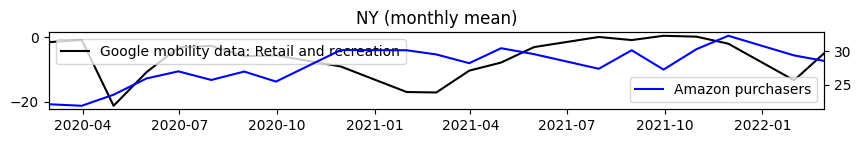

In [118]:
ax = get_monthly_correlation(mod_amzn_ps_monthly[state], mod_retail_monthly[state], state)

Product specific

In [119]:
amzn_data[
    (amzn_data[STATE]=='NY') & (amzn_data[YEAR].isin([2020, 2021]))
].groupby(CATEGORY)[RESPONSE_ID].nunique().sort_values(ascending=False).head(20)

Category
ABIS_BOOK                 260
ELECTRONIC_CABLE          158
SHIRT                     149
HEALTH_PERSONAL_CARE      148
NUTRITIONAL_SUPPLEMENT    144
HEADPHONES                144
CELLULAR_PHONE_CASE       138
PANTS                     132
SKIN_MOISTURIZER          126
SOCKS                     122
MEDICATION                115
SKIN_CLEANING_AGENT       115
SHOES                     111
SCREEN_PROTECTOR          111
CHARGING_ADAPTER          110
BATTERY                   110
BEAUTY                    109
CLEANING_AGENT            104
SAFETY_MASK               102
TOYS_AND_GAMES             96
Name: Survey ResponseID, dtype: int64

In [120]:
c = ['BEAUTY', 'HEALTH_PERSONAL_CARE', 'SKIN_CLEANING_AGENT']
c = ['BATTERY'] # yes stat significant
# c = ['CHARGING_ADAPTER', 'ELECTRONIC_CABLE'] # nearly stat. significant
# c = ['TOYS_AND_GAMES']
state = 'NY'
s_cat_amzn_ps_weekly = get_purchasers(amzn_data, state=state, categories=c, period='W')
s_cat_amzn_ps_monthly = get_purchasers(amzn_data, state=state, categories=c, period='M')
s_cat_amzn_ps_weekly.head()

Order Date
2018-01-14    1.0
2018-01-21    1.0
2018-01-28    1.0
2018-02-04    1.0
2018-02-11    1.0
Freq: W-SUN, Name: unique purchasers, dtype: float64

Correlation between months, modified to skip Amazon prime and December months
Pearson r=-0.464; p=0.0340
Spearman r=-0.443; p=0.0442


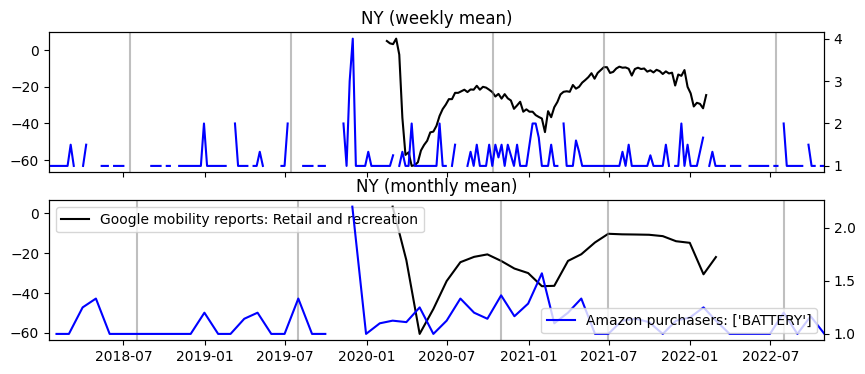

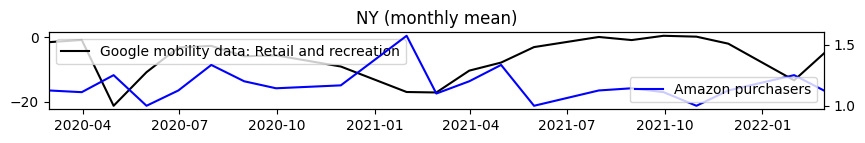

In [121]:

ax = plot_weekly_monthly_retail_vs_amzn(s_cat_amzn_ps_weekly, s_cat_amzn_ps_monthly, 
                                        retail_weekly[state], retail_monthly[state], state, cat=c)
s_cat_mod_amzn_ps_monthly = s_cat_amzn_ps_monthly.reindex(mod_retail_monthly.index)
ax = get_monthly_correlation(s_cat_mod_amzn_ps_monthly, mod_retail_monthly[state], state)

## Generalizing the retail analysis


Compute correlations and make table (s)

- columns: states
- rows: product categories
- cells: correlation coefficient

Do a table for 
- Pearson r
- Pearson pvalue
- Spearman r
- Spearman pvalue

states: states with at least X purchasers 2020-2021

product categories: top Y categories by distinct purchasers 2020-2021

In [122]:
# Get states to include in analysis
states_threshold_purchasers = 300
top_states = (amzn_data[amzn_data[YEAR].isin([2020,2021])]
              .groupby(STATE)[RESPONSE_ID].nunique()
              .sort_values(ascending=False))
top_states = top_states[top_states > states_threshold_purchasers]
print('Top states by number of distinct purchasers in 2020-2021')
display(top_states)
top_states = top_states.index

Top states by number of distinct purchasers in 2020-2021


Shipping Address State
CA    741
FL    600
TX    599
NY    492
PA    418
OH    340
IL    339
Name: Survey ResponseID, dtype: int64

In [123]:
# Get top product categories to incldue in analysis
top_cats_Y = 20
top_cats = (amzn_data[amzn_data[YEAR].isin([2020,2021])]
            .groupby(CATEGORY)[RESPONSE_ID].nunique()
            .sort_values(ascending=False).head(top_cats_Y))
display(top_cats)
top_cats = top_cats.index

Category
ABIS_BOOK                           3577
ELECTRONIC_CABLE                    2645
CELLULAR_PHONE_CASE                 2537
SHIRT                               2494
HEADPHONES                          2328
HEALTH_PERSONAL_CARE                2320
NUTRITIONAL_SUPPLEMENT              2026
PANTS                               1979
GIFT_CARD                           1954
SKIN_MOISTURIZER                    1911
SOCKS                               1897
SHOES                               1888
BATTERY                             1874
CHARGING_ADAPTER                    1873
SCREEN_PROTECTOR                    1771
CLEANING_AGENT                      1765
BEAUTY                              1738
MEDICATION                          1719
PORTABLE_ELECTRONIC_DEVICE_COVER    1691
SKIN_CLEANING_AGENT                 1684
Name: Survey ResponseID, dtype: int64

In [124]:
def get_n_purchasers_20202021(cat, state):
    return (amzn_data[
        amzn_data[YEAR].isin([2020,2021]) & (amzn_data[CATEGORY]==cat) & (amzn_data[STATE]==state)
    ][RESPONSE_ID].nunique())

In [125]:
purchasers = pd.DataFrame(
    {s: [get_n_purchasers_20202021(c, s) for c in top_cats] for s in top_states},
index=top_cats)
purchasers

CA   FL   TX   NY   PA   OH   IL
Category                                                           
ABIS_BOOK                         408  273  360  260  246  201  190
ELECTRONIC_CABLE                  293  181  198  158  149  128  117
CELLULAR_PHONE_CASE               251  177  218  138  146  114  107
SHIRT                             237  207  210  149  136  122  118
HEADPHONES                        239  156  206  144  129  105  109
HEALTH_PERSONAL_CARE              235  157  175  148  133  104  111
NUTRITIONAL_SUPPLEMENT            207  148  159  144  108   87   87
PANTS                             177  124  148  132  121   95   87
GIFT_CARD                          54   45   38   31   27   27   24
SKIN_MOISTURIZER                  210  130  140  126  113   76   96
SOCKS                             180  123  146  122  107   84   88
SHOES                             152  139  144  111   99  100   84
BATTERY                           220  114  145  110   94   92   88
CHARGING_ADAPTER                  193  139  159  110  102   81   87
SCREEN_PROTECTOR                  196  127  150  111  101   76   66
CLEANING_AGENT                    177  115  132  104  101   89   80
BEAUTY                            185  120  125  109   88   74   75
MEDICATION                        183  116  132  115  100   84   76
PORTABLE_ELECTRONIC_DEVICE_COVER  174  127  116   92   83   88   73
SKIN_CLEANING_AGENT               199  114  124  115  105   71   72

In [126]:
s_cat_pearson_r = {s: [] for s in top_states} # {state: [pearsonr(Amazon cat purchasers vs google retail) for each cat]}
s_cat_pearson_pvalue = {s: [] for s in top_states}
s_cat_spearman_r = {s: [] for s in top_states} # {state: [spearmanr(Amazon cat purchasers vs google retail) for each cat]}
s_cat_spearman_pvalue = {s: [] for s in top_states}

for i, s in enumerate(top_states):
    # get the monthly number of purchases for each category
    # modified to drop Amazon prime day and December months
    for c in top_cats:
        s_cat_amzn_ps_monthly = get_purchasers(amzn_data, state=s, categories=[c], period='M')
        mod_s_cat_amzn_ps_monthly = s_cat_amzn_ps_monthly.reindex(mod_retail_monthly.index).fillna(0)
        r, pvalue = pearsonr(mod_s_cat_amzn_ps_monthly, mod_retail_monthly[s])
        s_cat_pearson_r[s] += [r]
        s_cat_pearson_pvalue[s] += [pvalue]
        r, pvalue = spearmanr(mod_s_cat_amzn_ps_monthly, mod_retail_monthly[s])
        s_cat_spearman_r[s] += [r]
        s_cat_spearman_pvalue[s] += [pvalue]
s_cat_pearson_r = pd.DataFrame(s_cat_pearson_r, index=top_cats)
s_cat_pearson_pvalue = pd.DataFrame(s_cat_pearson_pvalue, index=top_cats)
s_cat_spearman_r = pd.DataFrame(s_cat_spearman_r, index=top_cats)
s_cat_spearman_pvalue = pd.DataFrame(s_cat_spearman_pvalue, index=top_cats)

In [127]:
display(s_cat_spearman_r)
s_cat_spearman_pvalue

CA        FL        TX        NY   
Category                                                                   
ABIS_BOOK                        -0.384540  0.050016 -0.094217  0.003248  \
ELECTRONIC_CABLE                 -0.335823 -0.005854  0.323482 -0.327699   
CELLULAR_PHONE_CASE              -0.149399  0.072893  0.116997 -0.048399   
SHIRT                             0.241066  0.407938  0.375935 -0.066970   
HEADPHONES                        0.154797  0.280768  0.332032 -0.133814   
HEALTH_PERSONAL_CARE             -0.014945  0.386594  0.200130 -0.348391   
NUTRITIONAL_SUPPLEMENT           -0.124471 -0.157296 -0.037675 -0.452033   
PANTS                             0.133940  0.374595 -0.203339  0.000000   
GIFT_CARD                        -0.532101  0.041758 -0.056455 -0.107940   
SKIN_MOISTURIZER                 -0.356841 -0.154847 -0.085798 -0.105607   
SOCKS                            -0.152796  0.149086  0.209667  0.402367   
SHOES                             0.232998 -0.046860  0.184836  0.374783   
BATTERY                          -0.044170 -0.087478  0.013017 -0.443153   
CHARGING_ADAPTER                 -0.518673 -0.078062 -0.070894 -0.011610   
SCREEN_PROTECTOR                 -0.362691  0.032552  0.244792  0.086327   
CLEANING_AGENT                   -0.100098 -0.007820 -0.260983 -0.179213   
BEAUTY                           -0.510570  0.028702 -0.173518 -0.356610   
MEDICATION                       -0.202927  0.001952  0.062459  0.053368   
PORTABLE_ELECTRONIC_DEVICE_COVER  0.307843 -0.096430  0.029145  0.327095   
SKIN_CLEANING_AGENT               0.048083  0.212033 -0.109333 -0.147618   

                                        PA        OH        IL  
Category                                                        
ABIS_BOOK                        -0.293506 -0.721302 -0.484730  
ELECTRONIC_CABLE                 -0.181523 -0.128949 -0.281626  
CELLULAR_PHONE_CASE               0.117727 -0.098268 -0.223143  
SHIRT                             0.366830  0.238204  0.021456  
HEADPHONES                        0.195940 -0.139859 -0.003291  
HEALTH_PERSONAL_CARE              0.021449  0.022114 -0.211520  
NUTRITIONAL_SUPPLEMENT           -0.145549 -0.476778 -0.001949  
PANTS                             0.173461  0.430899 -0.001980  
GIFT_CARD                        -0.028770 -0.200533  0.000000  
SKIN_MOISTURIZER                  0.029316 -0.062306  0.040229  
SOCKS                            -0.212553  0.242761 -0.087106  
SHOES                             0.499036  0.078850  0.499411  
BATTERY                           0.354375 -0.044548  0.030126  
CHARGING_ADAPTER                  0.124470 -0.257102 -0.008452  
SCREEN_PROTECTOR                 -0.040835 -0.111775 -0.110356  
CLEANING_AGENT                    0.153095  0.348422 -0.164986  
BEAUTY                            0.249911 -0.152396 -0.566777  
MEDICATION                        0.335283  0.058019 -0.165419  
PORTABLE_ELECTRONIC_DEVICE_COVER  0.412926 -0.120221 -0.026660  
SKIN_CLEANING_AGENT              -0.224252 -0.125795  0.309582

CA        FL        TX        NY   
Category                                                                   
ABIS_BOOK                         0.085218  0.829531  0.684578  0.988852  \
ELECTRONIC_CABLE                  0.136666  0.979909  0.152601  0.147017   
CELLULAR_PHONE_CASE               0.518050  0.753520  0.613518  0.834970   
SHIRT                             0.292486  0.066396  0.093050  0.773020   
HEADPHONES                        0.502865  0.217636  0.141430  0.563079   
HEALTH_PERSONAL_CARE              0.948735  0.083423  0.384409  0.121689   
NUTRITIONAL_SUPPLEMENT            0.590874  0.495909  0.871202  0.039660   
PANTS                             0.562707  0.094317  0.376671  1.000000   
GIFT_CARD                         0.013032  0.857374  0.807958  0.641417   
SKIN_MOISTURIZER                  0.112306  0.502724  0.711544  0.648680   
SOCKS                             0.508469  0.518937  0.361674  0.070562   
SHOES                             0.309426  0.840151  0.422491  0.094139   
BATTERY                           0.849222  0.706134  0.955342  0.044218   
CHARGING_ADAPTER                  0.015994  0.736618  0.760084  0.960166   
SCREEN_PROTECTOR                  0.106124  0.888601  0.284859  0.709840   
CLEANING_AGENT                    0.665957  0.973162  0.253169  0.436986   
BEAUTY                            0.018029  0.901710  0.451929  0.112556   
MEDICATION                        0.377660  0.993300  0.787960  0.818285   
PORTABLE_ELECTRONIC_DEVICE_COVER  0.174599  0.677549  0.900202  0.147808   
SKIN_CLEANING_AGENT               0.836032  0.356158  0.637095  0.523107   

                                        PA        OH        IL  
Category                                                        
ABIS_BOOK                         0.196593  0.000224  0.025945  
ELECTRONIC_CABLE                  0.431000  0.577481  0.216172  
CELLULAR_PHONE_CASE               0.611291  0.671731  0.330908  
SHIRT                             0.101903  0.298427  0.926448  
HEADPHONES                        0.394644  0.545409  0.988705  
HEALTH_PERSONAL_CARE              0.926471  0.924200  0.357349  
NUTRITIONAL_SUPPLEMENT            0.529012  0.028869  0.993309  
PANTS                             0.452080  0.051163  0.993202  
GIFT_CARD                         0.901480  0.383433  1.000000  
SKIN_MOISTURIZER                  0.899618  0.788469  0.862546  
SOCKS                             0.354951  0.289001  0.707331  
SHOES                             0.021280  0.734052  0.021167  
BATTERY                           0.114989  0.847947  0.896861  
CHARGING_ADAPTER                  0.590877  0.260551  0.970995  
SCREEN_PROTECTOR                  0.860494  0.629543  0.633928  
CLEANING_AGENT                    0.507629  0.121654  0.474804  
BEAUTY                            0.274585  0.509592  0.007383  
MEDICATION                        0.137339  0.802738  0.473628  
PORTABLE_ELECTRONIC_DEVICE_COVER  0.062827  0.603707  0.908674  
SKIN_CLEANING_AGENT               0.328447  0.586902  0.172052